In [25]:
from scipy.io import loadmat
import glob
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import numpy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import keras

from keras.models import Sequential
from keras.layers import Dense, Activation

In [2]:
ls /data/lisa/data/neuro/Meditation/time-series/cortex/

monk01_rest.mat       monk05_rest.mat       monk09_rest.mat
monk01_samatha.mat    monk05_samatha.mat    monk09_samatha.mat
monk01_vipassana.mat  monk05_vipassana.mat  monk09_vipassana.mat
monk02_rest.mat       monk06_rest.mat       monk10_rest.mat
monk02_samatha.mat    monk06_samatha.mat    monk10_samatha.mat
monk02_vipassana.mat  monk06_vipassana.mat  monk10_vipassana.mat
monk03_rest.mat       monk07_rest.mat       monk11_rest.mat
monk03_samatha.mat    monk07_samatha.mat    monk11_samatha.mat
monk03_vipassana.mat  monk07_vipassana.mat  monk11_vipassana.mat
monk04_rest.mat       monk08_rest.mat       monk12_rest.mat
monk04_samatha.mat    monk08_samatha.mat    monk12_samatha.mat
monk04_vipassana.mat  monk08_vipassana.mat  monk12_vipassana.mat


In [3]:
states = ['rest', 'samatha', 'vipassana']

# feature creation : filtered raw data

In [ ]:
from scipy import signal

def butter_filtfilt(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = signal.butter(order, [low, high], btype='band')

    return signal.filtfilt(b, a, data)

data_power = []
field_to_target = {'rest':0, 'samatha':1, 'vipassana':2}
frequencies = [('delta', 2, 4),
               ('theta', 5, 7),
               ('alpha', 8, 12),
               ('beta', 15, 29),
               ('gamma2', 60, 90)]

for monk in range(1, 13):
    print 'monk', monk
    features = []
    targets = []
    for field in ['rest', 'samatha', 'vipassana']:
        this_features = []
        d = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk%.2d_%s.mat'
            % (monk, field))['F']

        for freq, low, high in frequencies:
            this_features_freq = []
            filtered = butter_filtfilt(d, low, high, 600)

            power = (filtered**2).T
            for i in range(power.shape[0]/1000):
                if numpy.isnan(power[i*1000:(i+1)*1000]).any():
                    print i, power[i*1000:(i+1)*1000]
                    continue
                this_features_freq.append(power[i*1000:(i+1)*1000].mean(axis=0))

            this_features.append(this_features_freq)
        
        # (n_sensors, frequencies, timestamps)
        this_features = numpy.transpose(numpy.array(this_features), (1, 2, 0))
        print this_features.shape
        
        features.append(this_features)    
        targets.append(numpy.array([field_to_target[field]] * this_features.shape[0]))
    
    data_power.append((numpy.concatenate(features, axis=0), numpy.concatenate(targets, axis=0)))
    print data_power[-1][0].shape
    print data_power[-1][1].shape
    
del features, targets, this_features

# single monk

**erreur de méthodologie** : les features sont calculées sur des fenêtres qui se recoupent entre le train et le test

## time series shapes

In [4]:
d = dict()
for field in ['rest', 'samatha', 'vipassana']:
    d1 = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk01_%s.mat'
                % field)
    d[field] = d1['F']
    print field, d[field].shape

rest (148, 296419)
samatha (148, 656287)
vipassana (148, 652200)


## raw time series

Raw time series for state rest


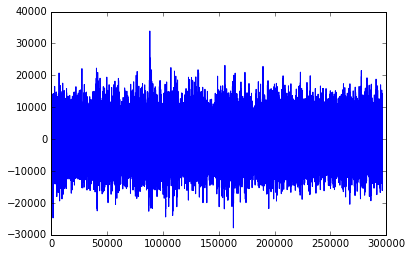

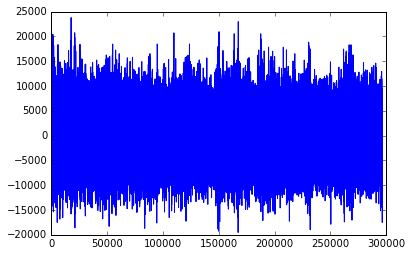

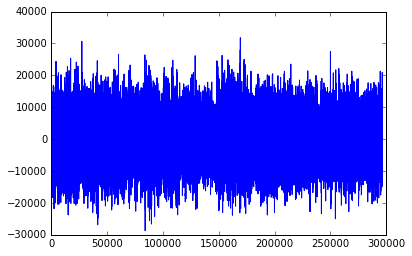

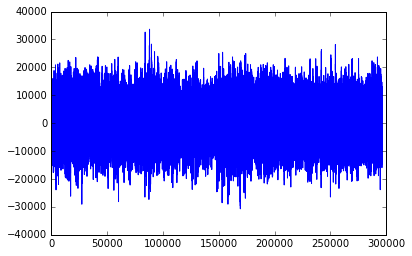

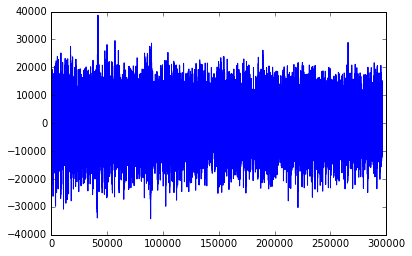

(296418,)


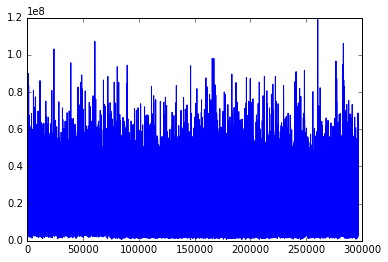

Raw time series for state samatha


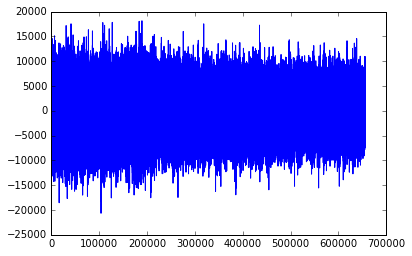

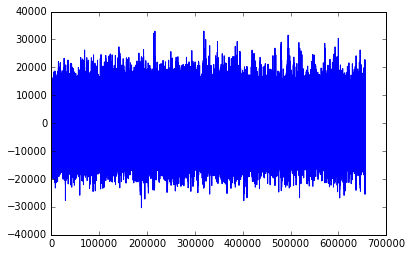

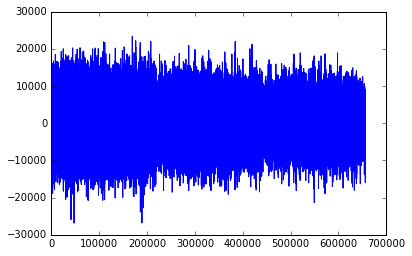

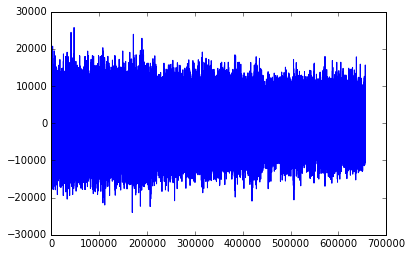

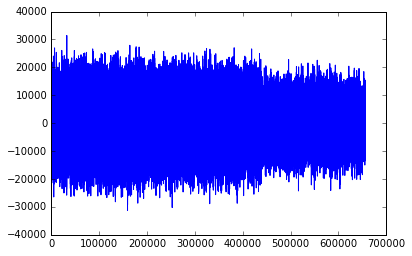

(656286,)


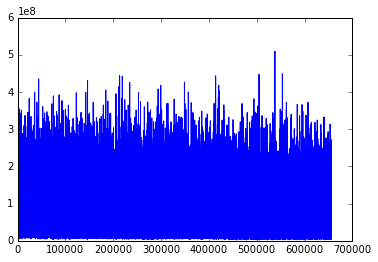

Raw time series for state vipassana


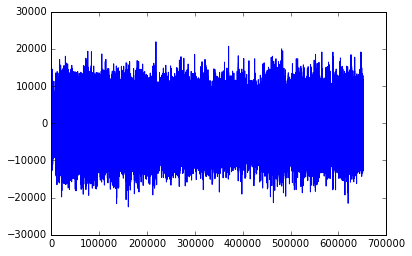

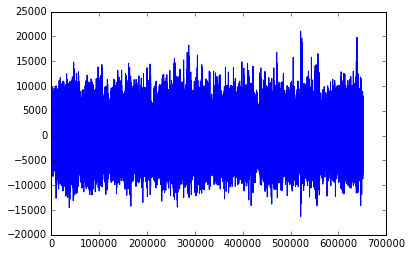

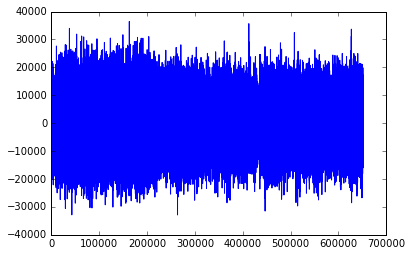

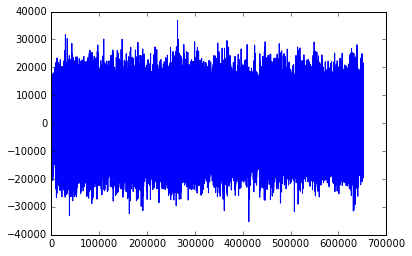

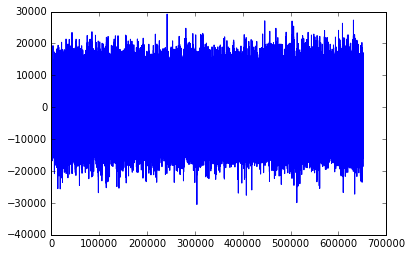

(652199,)


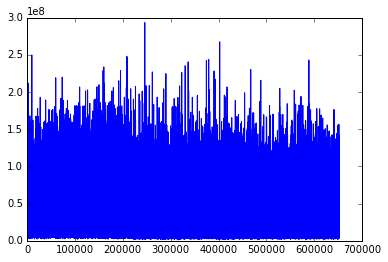

In [5]:
for field in ['rest', 'samatha', 'vipassana']:
    print 'Raw time series for state %s' % field
    for i in range(5):
        plt.plot(d[field][i,:])
        plt.show()
        
    diff = ((d[field][:,1:] - d[field][:,:-1]) ** 2).mean(axis=0)
    print diff.shape
    plt.plot(diff)
    plt.show()

## spectrograms

Spectrograms for state rest


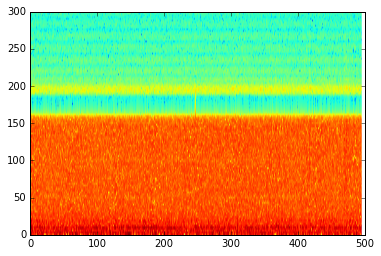

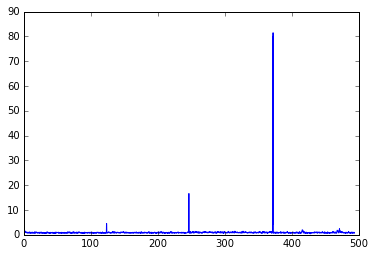

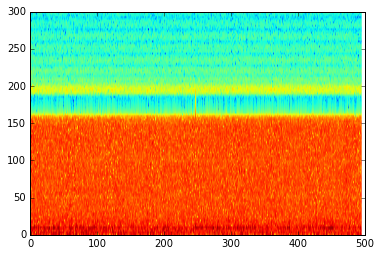

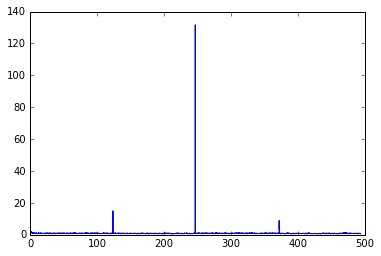

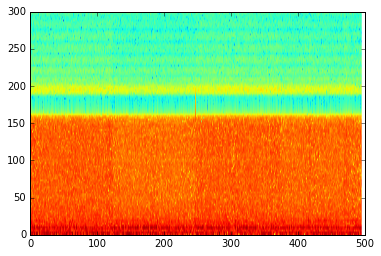

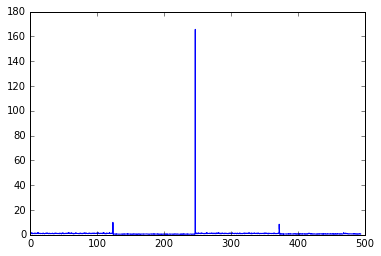

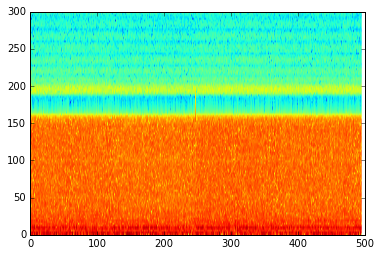

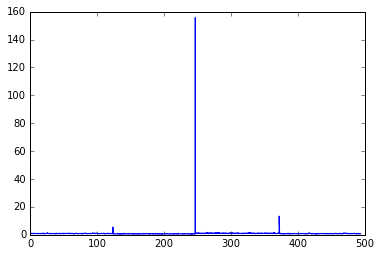

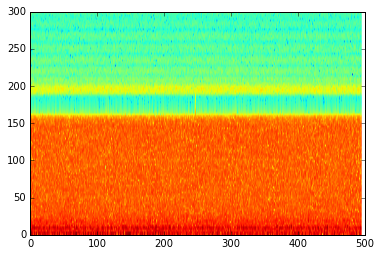

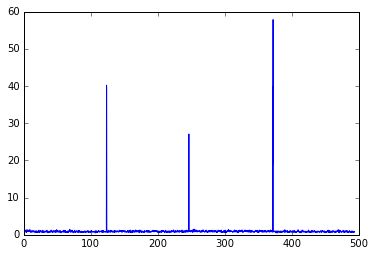

Spectrograms for state samatha


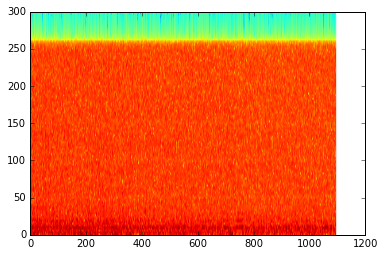

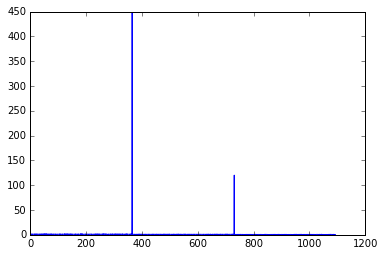

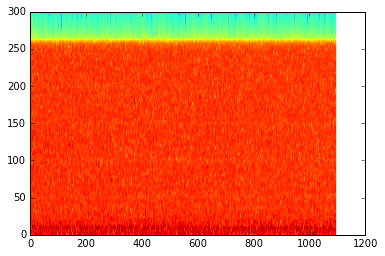

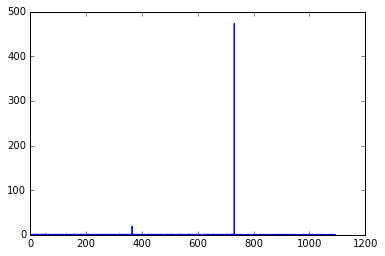

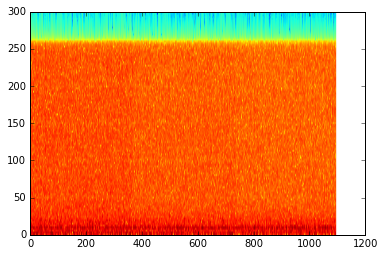

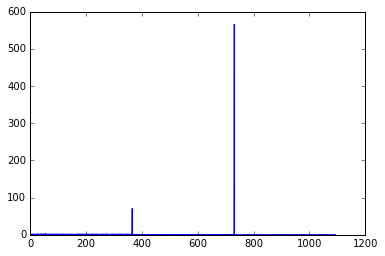

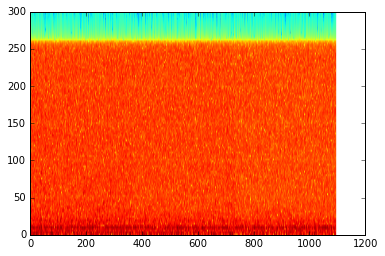

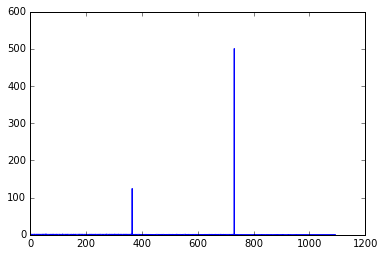

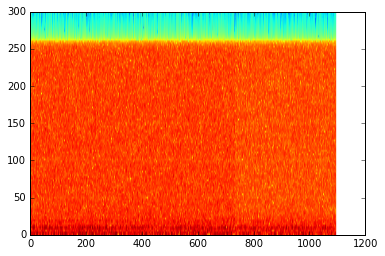

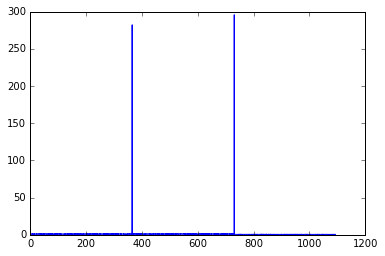

Spectrograms for state vipassana


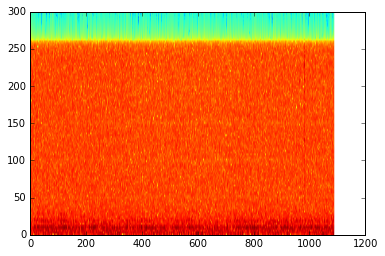

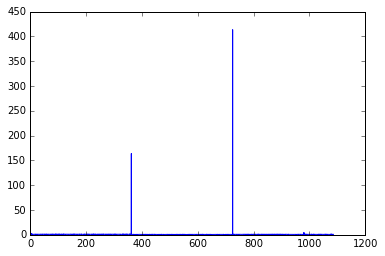

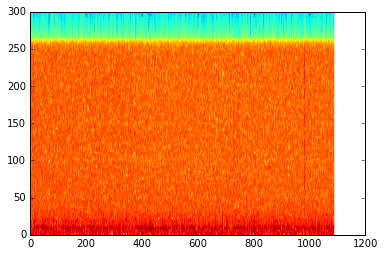

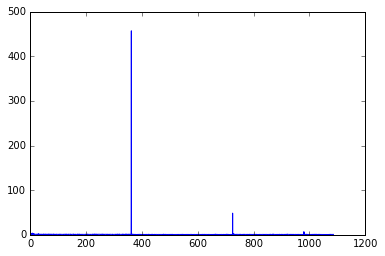

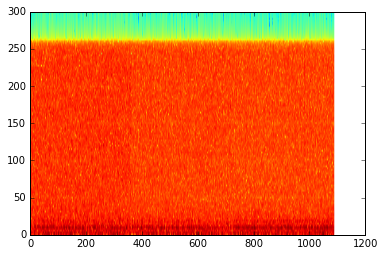

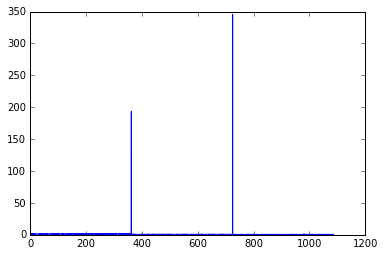

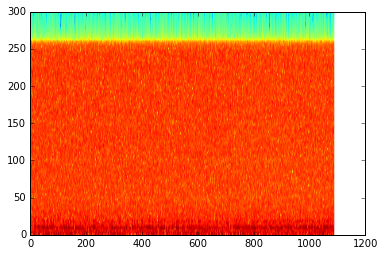

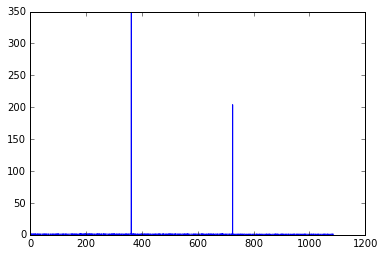

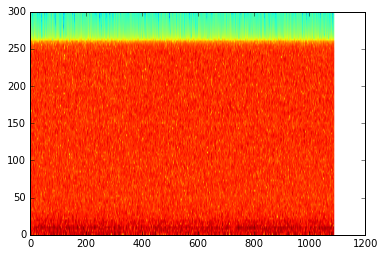

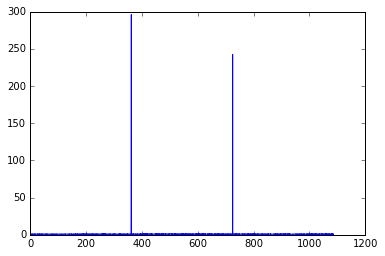

In [6]:
for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    for i in range(5):
        s, fs, ts, _ = plt.specgram(d[field][i,:], Fs=600)
        diff = (numpy.abs(s[:,1:] - s[:,:-1]) / s.mean(axis=1, keepdims=True)).mean(axis=0)
        plt.show()
        plt.plot(ts[:-1], diff)
        plt.show()

## classification using spectrogram features for a single sensor

first we build a tensor of size (timesteps x number of sensor x freqs) for each state

In [7]:
features_dict = dict()

for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    features = []
    for i in range(d[field].shape[0]):
        s, fs, ts = mlab.specgram(d[field][i,:], Fs=600)
        features.append(s)
    features_dict[field] = numpy.rollaxis(numpy.array(features), 2)
    print features_dict[field].shape

Spectrograms for state rest
(2314, 148, 129)
Spectrograms for state samatha
(5126, 148, 129)
Spectrograms for state vipassana
(5094, 148, 129)


for each sensor, train a classifier and print its score on a valid set

In [8]:
indices = numpy.arange(sum([features_dict[f].shape[0] for f in states]))
numpy.random.shuffle(indices)

targets = numpy.array([0] * features_dict['rest'].shape[0]
                      + [1] * features_dict['samatha'].shape[0]
                      + [2] * features_dict['vipassana'].shape[0])
targets = targets[indices]

train = slice(0, 10000)
test = slice(10000, len(indices))

for sensor in range(features_dict['rest'].shape[1]):
    features = numpy.concatenate([
            features_dict['rest'][:,sensor,:],
            features_dict['samatha'][:,sensor,:],
            features_dict['vipassana'][:,sensor,:],
        ], axis=0)
    
    features = features[indices]
    
    gnb = GaussianNB()
    y_fit = gnb.fit(features[train], targets[train])
    y_pred_train = y_fit.predict(features[train])
    y_pred_test = y_fit.predict(features[test])
    
    print 'Misclassified for sensor %d:' % (sensor, ),
    print float((y_pred_train != targets[train]).sum()) / 10000,
    print float((y_pred_test != targets[test]).sum()) / (test.stop - test.start)

Misclassified for sensor 0: 0.2305 0.220599842147
Misclassified for sensor 1: 0.0023 0.00157853196527
Misclassified for sensor 2: 0.0305 0.0284135753749
Misclassified for sensor 3: 0.0204 0.0193370165746
Misclassified for sensor 4: 0.2513 0.253354380426
Misclassified for sensor 5: 0.1738 0.165745856354
Misclassified for sensor 6: 0.2575 0.259668508287
Misclassified for sensor 7: 0.2694 0.286108918706
Misclassified for sensor 8: 0.0052 0.008681925809
Misclassified for sensor 9: 0.0034 0.00157853196527
Misclassified for sensor 10: 0.0009 0.000789265982636
Misclassified for sensor 11: 0.0334 0.0331491712707
Misclassified for sensor 12: 0.1358 0.133385951066
Misclassified for sensor 13: 0.2205 0.228492501973
Misclassified for sensor 14: 0.1338 0.1318074191
Misclassified for sensor 15: 0.003 0.00315706393054
Misclassified for sensor 16: 0.0307 0.0295974743489
Misclassified for sensor 17: 0.0331 0.0299921073402
Misclassified for sensor 18: 0.271 0.277032359905
Misclassified for sensor 19: 0.

# Single monk #2

## logistic regression

In [40]:
confusions_train = []
confusions_test = []

print 'Train error, test error, test error with random predictor'

for monk_out in range(1, 13):
    confusion_train = numpy.zeros((3, 3))
    confusion_test = numpy.zeros((3, 3))
    
    X = data_power[monk_out-1][0]
    Y = data_power[monk_out-1][1]

    indices = numpy.arange(X.shape[0])
    numpy.random.shuffle(indices)
    
    train_x = X[indices[:int(X.shape[0]*.75)]]
    test_x = X[indices[int(X.shape[0]*.75):]]
    train_y = Y[indices[:int(X.shape[0]*.75)]]
    test_y = Y[indices[int(X.shape[0]*.75):]]
        
    train_y_onehot = numpy.zeros((train_y.shape[0], 3))
    train_y_onehot[numpy.arange(train_y.shape[0]), train_y[0]] = 1
    train_x = train_x.reshape(train_x.shape[0], -1)
    test_y_onehot = numpy.zeros((test_y.shape[0], 3))
    test_y_onehot[numpy.arange(test_y.shape[0]), test_y[0]] = 1
    test_x = test_x.reshape(test_x.shape[0], -1)

    
    model = Sequential([
        Dense(3, input_dim=train_x.shape[1]),
        Activation('softmax'),
    ])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    y_fit = model.fit(train_x, train_y_onehot, nb_epoch=250, batch_size=32, verbose=0)
    y_pred_train = numpy.argmax(model.predict(train_x), axis=1)
    y_pred_test = numpy.argmax(model.predict(test_x), axis=1)
    
    for p, t in zip(y_pred_train, train_y):
        confusion_train[p,t] += 1
    for p, t in zip(y_pred_test, test_y):
        confusion_test[p,t] += 1
    confusions_train.append(confusion_train)
    confusions_test.append(confusion_test)
    
    print 'Monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y),
    print float((test_y != numpy.random.randint(0, 3, y_pred_test.shape)).sum()) / len(test_y) 

Train error, test error, test error with random predictor
Monk 1: 0.692435577722 0.725685785536 0.673316708229
Monk 2: 0.629186602871 0.63245823389 0.663484486874
Monk 3: 0.83698296837 0.822384428224 0.676399026764
Monk 4: 0.754838709677 0.768488745981 0.672025723473
Monk 5: 0.54565376187 0.571115973742 0.654266958425
Monk 6: 0.656071719641 0.680487804878 0.656097560976
Monk 7: 0.54714064915 0.527777777778 0.625
Monk 8: 0.587402689314 0.617834394904 0.675159235669
Monk 9: 0.898305084746 0.905797101449 0.683574879227
Monk 10: 0.733333333333 0.708571428571 0.642857142857
Monk 11: 0.917312661499 0.938144329897 0.646907216495
Monk 12: 0.585069444444 0.605194805195 0.633766233766


## 1 nn

In [39]:
confusions_train = []
confusions_test = []

for monk_out in range(1, 13):
    confusion_train = numpy.zeros((3,3))
    confusion_test = numpy.zeros((3,3))
    
    print 'I will leave monk %d out' % (monk_out)
    
    X = data_power[monk_out-1][0]
    Y = data_power[monk_out-1][1]

    indices = numpy.arange(X.shape[0])
    numpy.random.shuffle(indices)
    
    train_x = X[indices[:int(X.shape[0]*.75)]]
    test_x = X[indices[int(X.shape[0]*.75):]]
    train_y = Y[indices[:int(X.shape[0]*.75)]]
    test_y = Y[indices[int(X.shape[0]*.75):]]
        
    train_y_onehot = numpy.zeros((train_y.shape[0], 3))
    train_y_onehot[numpy.arange(train_y.shape[0]), train_y[0]] = 1
    train_x = train_x.reshape(train_x.shape[0], -1)
    test_y_onehot = numpy.zeros((test_y.shape[0], 3))
    test_y_onehot[numpy.arange(test_y.shape[0]), test_y[0]] = 1
    test_x = test_x.reshape(test_x.shape[0], -1)
    
    knn = KNeighborsClassifier(n_neighbors=1)
    
    y_fit = knn.fit(train_x, train_y)
    y_pred_train = y_fit.predict(train_x)
    y_pred_test = y_fit.predict(test_x)
    
    for p, t in zip(y_pred_train, train_y):
        confusion_train[p,t] += 1
    for p, t in zip(y_pred_test, test_y):
        confusion_test[p,t] += 1
    confusions_train.append(confusion_train)
    confusions_test.append(confusion_test)
    
    print 'Misclassified for monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y)

I will leave monk 1 out
Misclassified for monk 1: 0.0 0.0374064837905
I will leave monk 2 out
Misclassified for monk 2: 0.0 0.0859188544153
I will leave monk 3 out
Misclassified for monk 3: 0.0 0.0
I will leave monk 4 out
Misclassified for monk 4: 0.0 0.0
I will leave monk 5 out
Misclassified for monk 5: 0.0 0.0
I will leave monk 6 out
Misclassified for monk 6: 0.0 0.00975609756098
I will leave monk 7 out
Misclassified for monk 7: 0.0 0.0
I will leave monk 8 out
Misclassified for monk 8: 0.0 0.178343949045
I will leave monk 9 out
Misclassified for monk 9: 0.0 0.00724637681159
I will leave monk 10 out
Misclassified for monk 10: 0.0 0.00285714285714
I will leave monk 11 out
Misclassified for monk 11: 0.0 0.0
I will leave monk 12 out
Misclassified for monk 12: 0.0 0.0


# inter monk

**erreur de méthodologie** : les features sont calculées sur des fenêtres qui se recoupent entre le train et le test

Experimental results

| Monk        | Sensor with best accuracy | Misclassification rate for this sensor  |
|:------------:|:-------------:|:-----:|
| 2 | 147 | .001  |
| 3 | 126 | 0.013 |
| 4 | 10  | 0.23  |
| 5 | 94  | 0.12  |
| 6 | 141 | 0.24  |
| 7 | 131 | 0.037 |
| 8 | 94  | 0.16  |

In [9]:
d2 = dict()
for field in ['rest', 'samatha', 'vipassana']:
    d1 = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk08_%s.mat'
                % field)
    d2[field] = d1['F']
    print field, d[field].shape

rest (148, 296419)
samatha (148, 656287)
vipassana (148, 652200)


In [10]:
features_dict2 = dict()

for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    features = []
    for i in range(d2[field].shape[0]):
        s, fs, ts = mlab.specgram(d2[field][i,:], Fs=600)
        features.append(s)
    features_dict2[field] = numpy.rollaxis(numpy.array(features), 2)
    print features_dict2[field].shape

Spectrograms for state rest
(4401, 148, 129)
Spectrograms for state samatha
(5254, 148, 129)
Spectrograms for state vipassana
(5069, 148, 129)


In [11]:
targets = numpy.array([0] * features_dict['rest'].shape[0]
                      + [1] * features_dict['samatha'].shape[0]
                      + [2] * features_dict['vipassana'].shape[0])
targets2 = numpy.array([0] * features_dict2['rest'].shape[0]
                       + [1] * features_dict2['samatha'].shape[0]
                       + [2] * features_dict2['vipassana'].shape[0])


for sensor in range(features_dict['rest'].shape[1]):
    features = numpy.concatenate([
            features_dict['rest'][:,sensor,:],
            features_dict['samatha'][:,sensor,:],
            features_dict['vipassana'][:,sensor,:],
        ], axis=0)
    features_test = numpy.concatenate([
        features_dict2['rest'][:,sensor,:],
        features_dict2['samatha'][:,sensor,:],
        features_dict2['vipassana'][:,sensor,:],
    ], axis=0)
    
    gnb = GaussianNB()
    y_fit = gnb.fit(features, targets)
    y_pred_train = y_fit.predict(features)
    y_pred_test = y_fit.predict(features_test)
    
    print 'Misclassified for sensor %d:' % (sensor, ),
    print float((y_pred_train != targets).sum()) / len(targets),
    print float((y_pred_test != targets2).sum()) / len(targets2)

Misclassified for sensor 0: 0.227780437211 0.402336321652
Misclassified for sensor 1: 0.00215414073719 0.342705786471
Misclassified for sensor 2: 0.0299186213499 0.486688399891
Misclassified for sensor 3: 0.0205042284985 0.221882640587
Misclassified for sensor 4: 0.251077070369 0.341415376256
Misclassified for sensor 5: 0.172251475985 0.345218690573
Misclassified for sensor 6: 0.258656454444 0.354998641673
Misclassified for sensor 7: 0.274932184458 0.347324096713
Misclassified for sensor 8: 0.00590394127972 0.449470252649
Misclassified for sensor 9: 0.00311153662039 0.804808475958
Misclassified for sensor 10: 0.000877612892931 0.43289866884
Misclassified for sensor 11: 0.0339077708633 0.233767997827
Misclassified for sensor 12: 0.135391734482 0.487842977452
Misclassified for sensor 13: 0.22155736397 0.372928552024
Misclassified for sensor 14: 0.134194989628 0.273634881826
Misclassified for sensor 15: 0.00303175363013 0.248166259169
Misclassified for sensor 16: 0.030237753311 0.34494702

# leave one monk out, spectrogram features

In [12]:
data = []
field_to_target = {'rest':0, 'samatha':1, 'vipassana':2}

for monk in range(1, 13):
    print 'monk', monk
    features = []
    targets = []
    for field in ['rest', 'samatha', 'vipassana']:
        this_features = []
        d = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk%.2d_%s.mat'
            % (monk, field))['F']
        for i in range(d.shape[0]):
            s, fs, ts = mlab.specgram(d[i,:], Fs=600, NFFT=512)
            this_features.append(s[:129,:])
        
        # (n_sensors, frequencies, timestamps)
        this_features = numpy.array(this_features)
        print this_features.shape
        
        features.append(this_features)    
        targets.append(numpy.array([field_to_target[field]] * s.shape[1]))
    
    data.append((numpy.concatenate(features, axis=2), numpy.concatenate(targets, axis=0)))
    print data[-1][0].shape
    print data[-1][1].shape
    
del features, targets, this_features, s

monk 1
(148, 129, 771)
(148, 129, 1708)
(148, 129, 1698)
(148, 129, 4177)
(4177,)
monk 2
(148, 129, 1027)
(148, 129, 1655)
(148, 129, 1677)
(148, 129, 4359)
(4359,)
monk 3
(148, 129, 992)
(148, 129, 1653)
(148, 129, 1637)
(148, 129, 4282)
(4282,)
monk 4
(148, 129, 1334)
(148, 129, 906)
(148, 129, 993)
(148, 129, 3233)
(3233,)
monk 5
(148, 129, 1343)
(148, 129, 1705)
(148, 129, 1706)
(148, 129, 4754)
(4754,)
monk 6
(148, 129, 854)
(148, 129, 1702)
(148, 129, 1710)
(148, 129, 4266)
(4266,)
monk 7
(148, 129, 1073)
(148, 129, 1723)
(148, 129, 1702)
(148, 129, 4498)
(4498,)
monk 8
(148, 129, 1467)
(148, 129, 1751)
(148, 129, 1689)
(148, 129, 4907)
(4907,)
monk 9
(148, 129, 1006)
(148, 129, 1646)
(148, 129, 1653)
(148, 129, 4305)
(4305,)
monk 10
(148, 129, 851)
(148, 129, 1119)
(148, 129, 1676)
(148, 129, 3646)
(3646,)
monk 11
(148, 129, 754)
(148, 129, 1665)
(148, 129, 1617)
(148, 129, 4036)
(4036,)
monk 12
(148, 129, 673)
(148, 129, 1664)
(148, 129, 1666)
(148, 129, 4003)
(4003,)


In [13]:
confusions_train = []
confusions_test = []

for monk_out in range(1, 13):
    confusion_train = numpy.zeros((3,3))
    confusion_test = numpy.zeros((3,3))
    
    print 'I will leave monk %d out' % (monk_out)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for monk in range(1, 13):
        if monk == monk_out:
            test_x.append(data[monk-1][0])
            test_y.append(data[monk-1][1])
        else:
            train_x.append(data[monk-1][0])
            train_y.append(data[monk-1][1])
        
    train_x = numpy.concatenate(train_x, axis=2)
    train_y = numpy.concatenate(train_y, axis=0)
    train_x = train_x.reshape(-1, train_x.shape[2]).transpose()
    test_x = numpy.concatenate(test_x, axis=2)
    test_y = numpy.concatenate(test_y, axis=0)
    test_x = test_x.reshape(-1, test_x.shape[2]).transpose()
    
    gnb = GaussianNB()
    
    y_fit = gnb.fit(train_x, train_y)
    y_pred_train = y_fit.predict(train_x)
    y_pred_test = y_fit.predict(test_x)
    
    for p, t in zip(y_pred_train, train_y):
        confusion_train[p,t] += 1
    for p, t in zip(y_pred_test, test_y):
        confusion_test[p,t] += 1
    confusions_train.append(confusion_train)
    confusions_test.append(confusion_test)
    
    print 'Misclassified for monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y)

I will leave monk 1 out
Misclassified for monk 1: 0.378037978785 0.5152022983
I will leave monk 2 out
Misclassified for monk 2: 0.350705966556 0.634319798119
I will leave monk 3 out
Misclassified for monk 3: 0.348107569721 0.985287248949
I will leave monk 4 out
Misclassified for monk 4: 0.373658247412 0.776678008042
I will leave monk 5 out
Misclassified for monk 5: 0.35413020651 0.71539755995
I will leave monk 6 out
Misclassified for monk 6: 0.354632034632 0.767932489451
I will leave monk 7 out
Misclassified for monk 7: 0.322833275322 0.7563361494
I will leave monk 8 out
Misclassified for monk 8: 0.348383414913 0.659873649888
I will leave monk 9 out
Misclassified for monk 9: 0.364095231906 0.831823461092
I will leave monk 10 out
Misclassified for monk 10: 0.35055531824 0.713933077345
I will leave monk 11 out
Misclassified for monk 11: 0.386991169502 0.937314172448
I will leave monk 12 out
Misclassified for monk 12: 0.302821599983 0.861104171871


## matrices de confusion

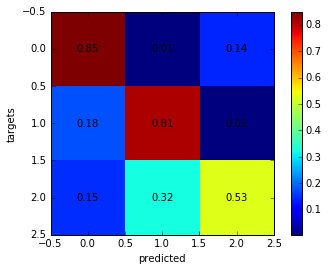

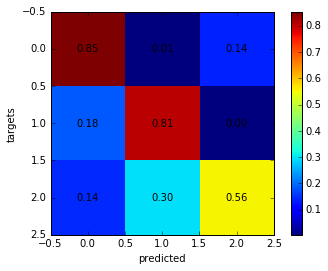

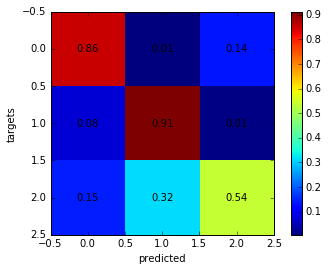

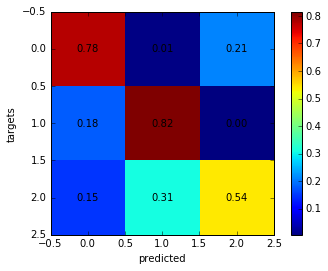

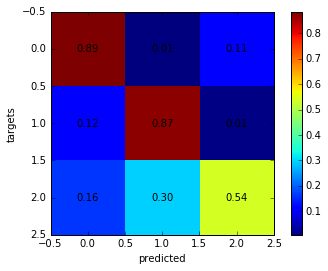

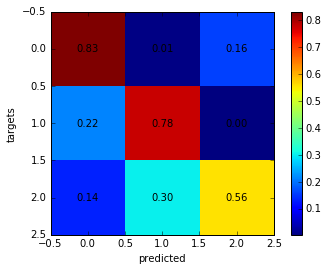

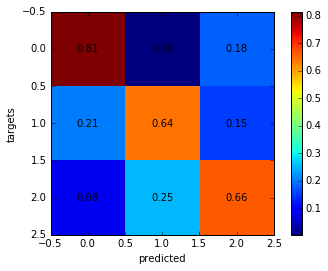

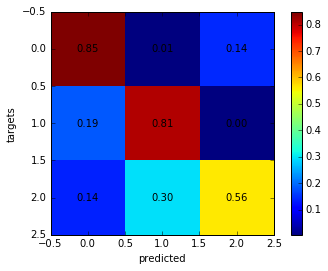

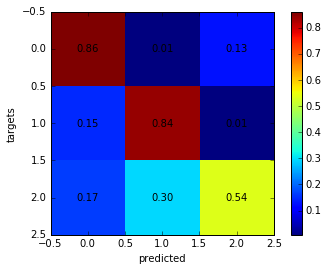

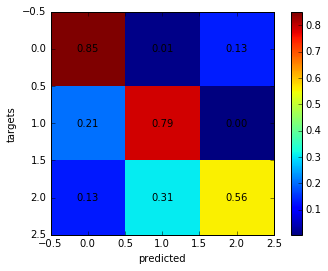

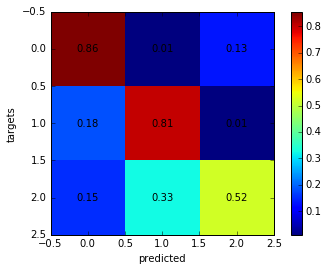

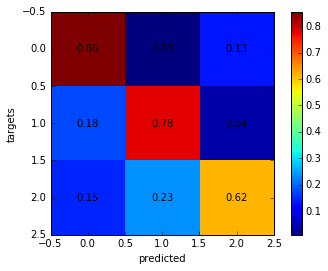

In [14]:
for conf in confusions_train:
    c = conf/conf.sum(axis=1, keepdims=True)
    res = plt.imshow(c, interpolation='nearest')
    for i,j in ((x,y) for x in xrange(3)
            for y in xrange(3)):
        plt.annotate('%.2f' % (c[i][j],),xy=(j,i),horizontalalignment='center',
                    verticalalignment='center')
    plt.xlabel('predicted')
    plt.ylabel('targets')
    plt.colorbar(res)
    plt.show()

# leave one monk out, standard eeg power features

## gaussian naive bayes

In [16]:
confusions_train = []
confusions_test = []

for monk_out in range(1, 13):
    confusion_train = numpy.zeros((3,3))
    confusion_test = numpy.zeros((3,3))
    
    print 'I will leave monk %d out' % (monk_out)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for monk in range(1, 13):
        if monk == monk_out:
            test_x.append(data_power[monk-1][0])
            test_y.append(data_power[monk-1][1])
        else:
            train_x.append(data_power[monk-1][0])
            train_y.append(data_power[monk-1][1])
        
    train_x = numpy.concatenate(train_x, axis=0)
    train_y = numpy.concatenate(train_y, axis=0)
    train_x = train_x.reshape(train_x.shape[0], -1)
    test_x = numpy.concatenate(test_x, axis=0)
    test_y = numpy.concatenate(test_y, axis=0)
    test_x = test_x.reshape(test_x.shape[0], -1)
    
    gnb = GaussianNB()
    
    y_fit = gnb.fit(train_x, train_y)
    y_pred_train = y_fit.predict(train_x)
    y_pred_test = y_fit.predict(test_x)
    
    for p, t in zip(y_pred_train, train_y):
        confusion_train[p,t] += 1
    for p, t in zip(y_pred_test, test_y):
        confusion_test[p,t] += 1
    confusions_train.append(confusion_train)
    confusions_test.append(confusion_test)
    
    print 'Misclassified for monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y)

I will leave monk 1 out
Misclassified for monk 1: 0.372763083849 0.547381546135
I will leave monk 2 out
Misclassified for monk 2: 0.34738150387 0.643156007173
I will leave monk 3 out
Misclassified for monk 3: 0.338635081782 0.94099756691
I will leave monk 4 out
Misclassified for monk 4: 0.364363315502 0.717969379533
I will leave monk 5 out
Misclassified for monk 5: 0.363688169592 0.65717415115
I will leave monk 6 out
Misclassified for monk 6: 0.345830749281 0.752596212584
I will leave monk 7 out
Misclassified for monk 7: 0.361570716228 0.483777520278
I will leave monk 8 out
Misclassified for monk 8: 0.349170954831 0.605626326964
I will leave monk 9 out
Misclassified for monk 9: 0.372270187913 0.782819116757
I will leave monk 10 out
Misclassified for monk 10: 0.333036608434 0.665714285714
I will leave monk 11 out
Misclassified for monk 11: 0.375315568022 0.777275661717
I will leave monk 12 out
Misclassified for monk 12: 0.365868699893 0.867273910215


### plot with error bars

#### all monks

(19374, 148, 5)


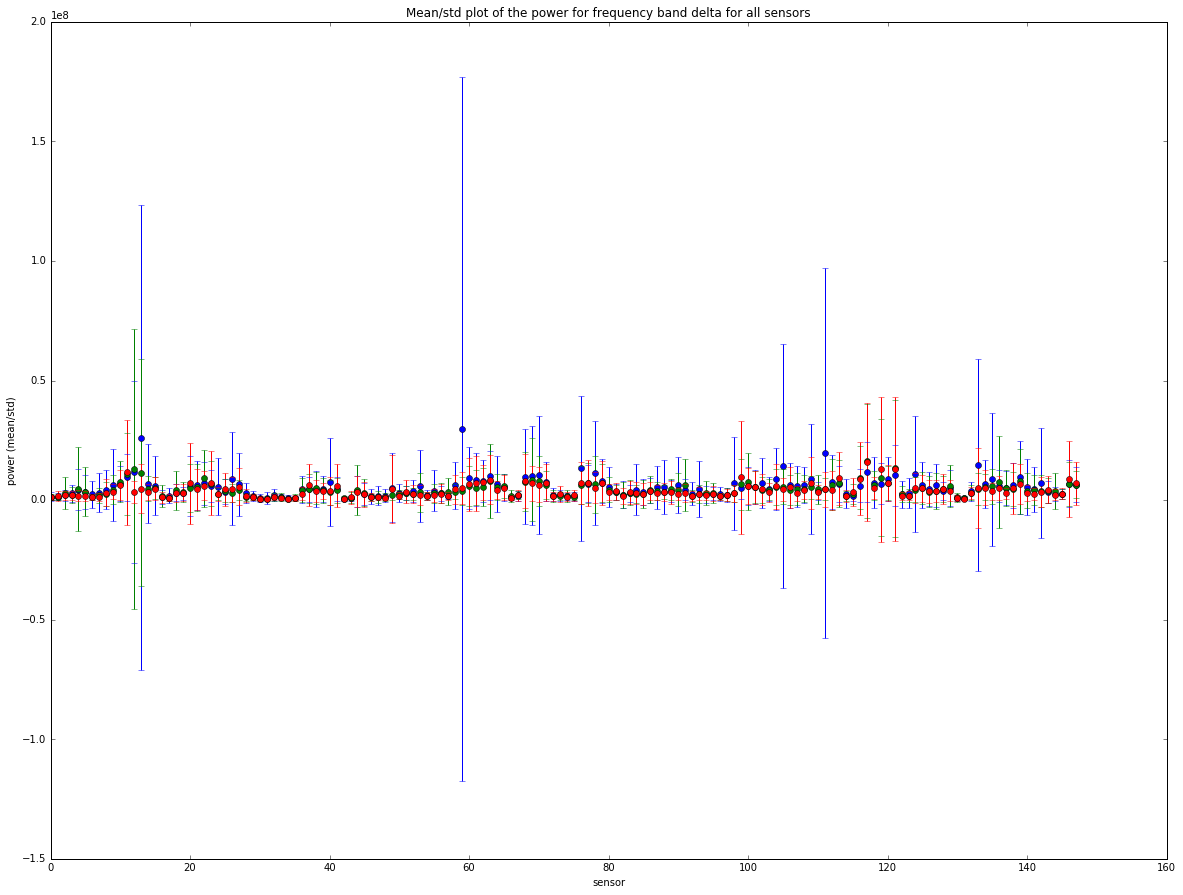

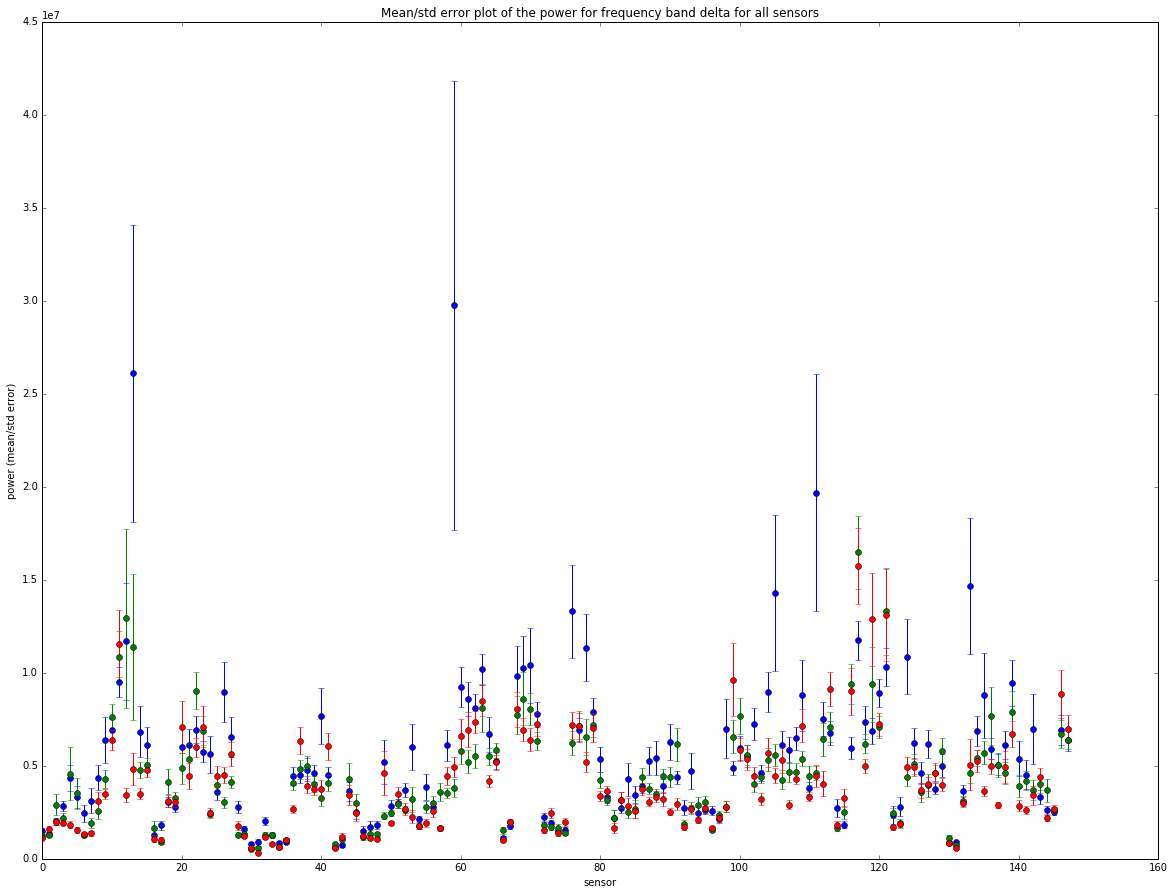

(19374, 148, 5)


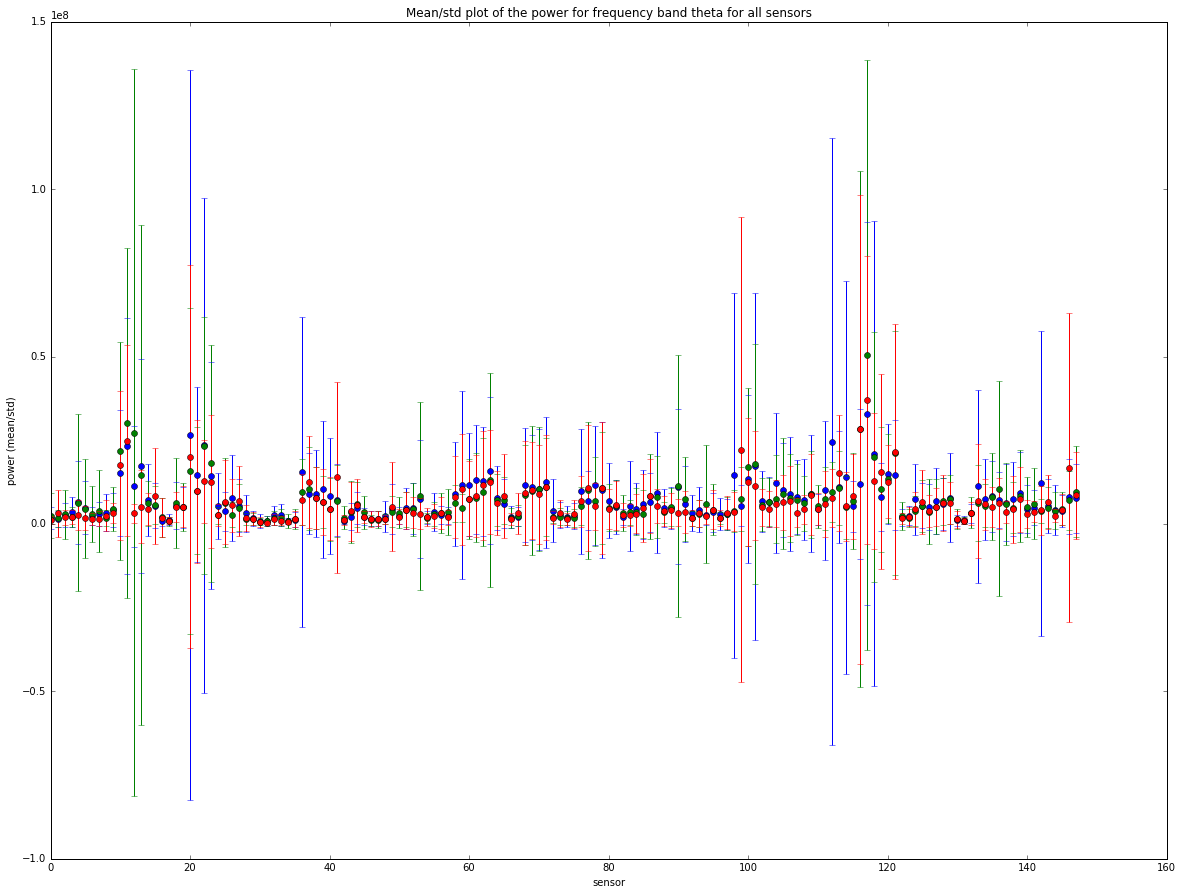

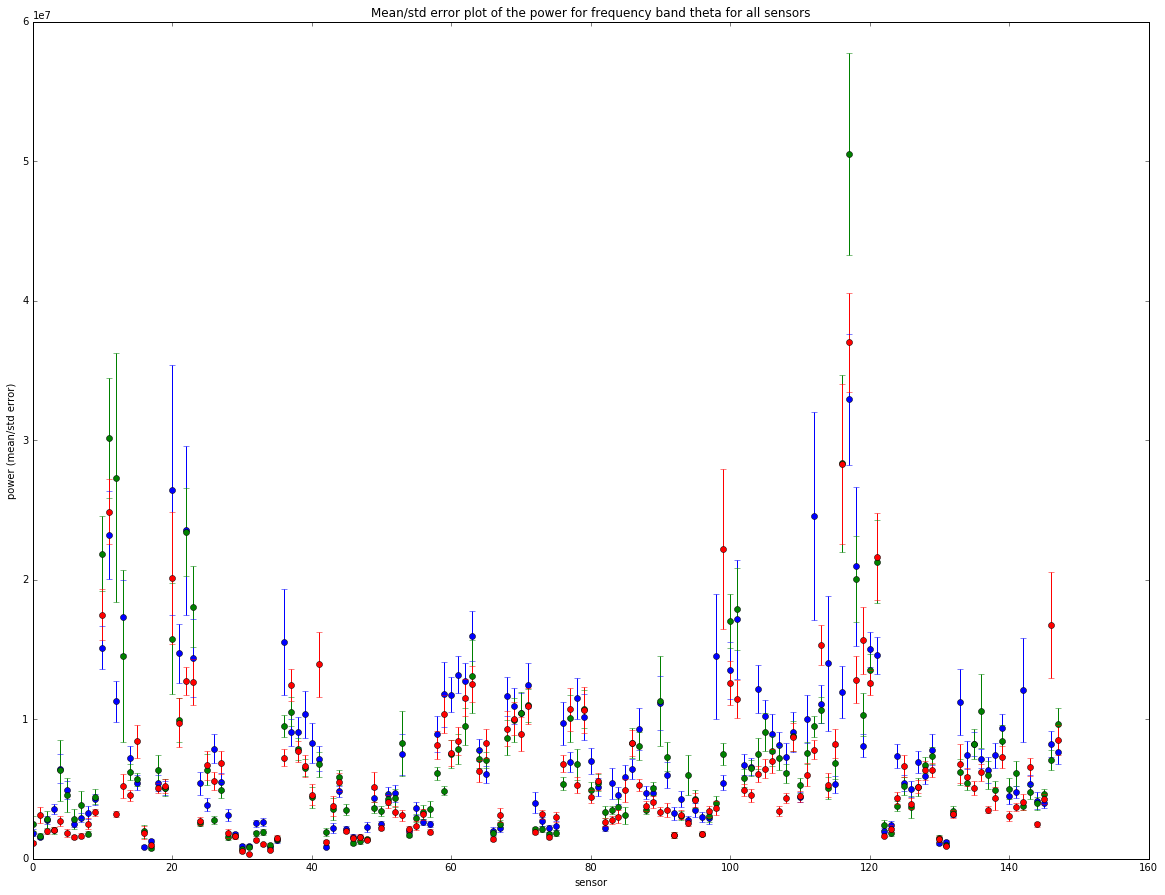

(19374, 148, 5)


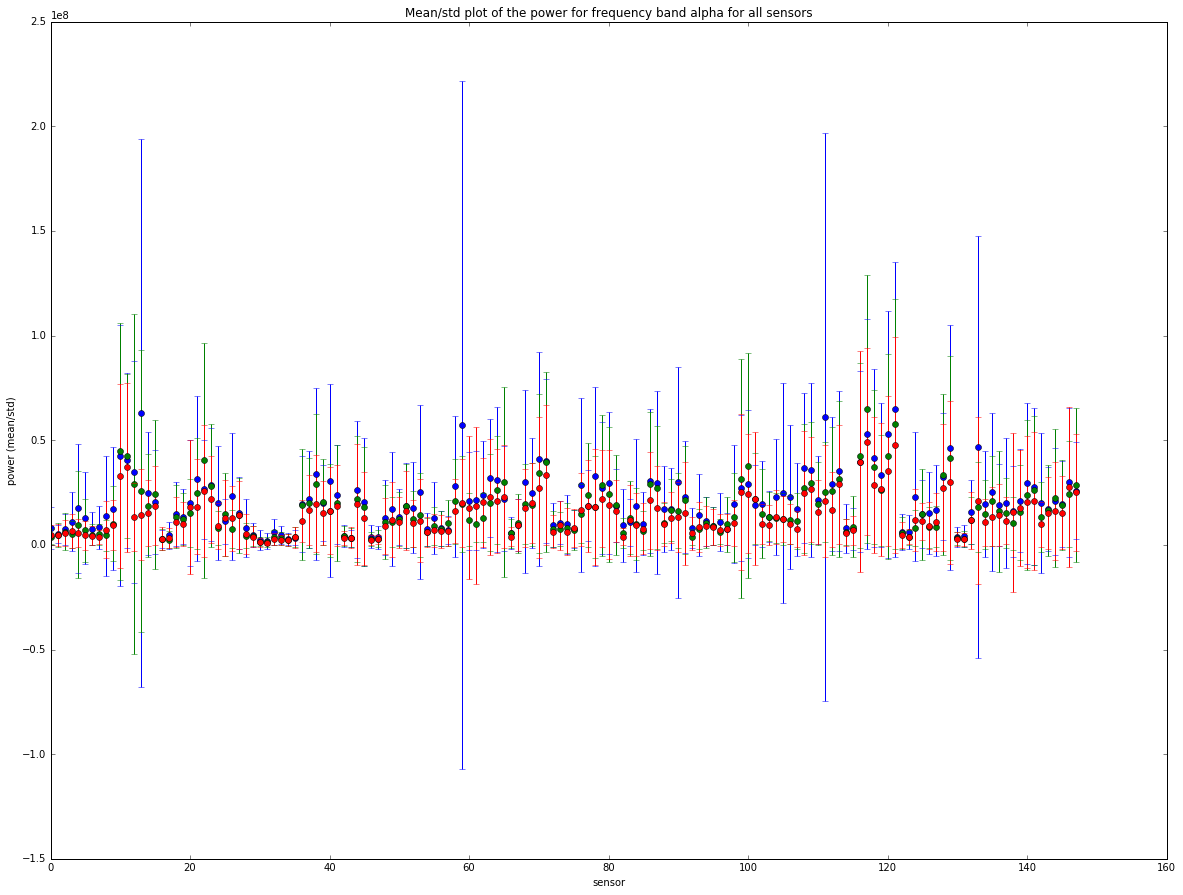

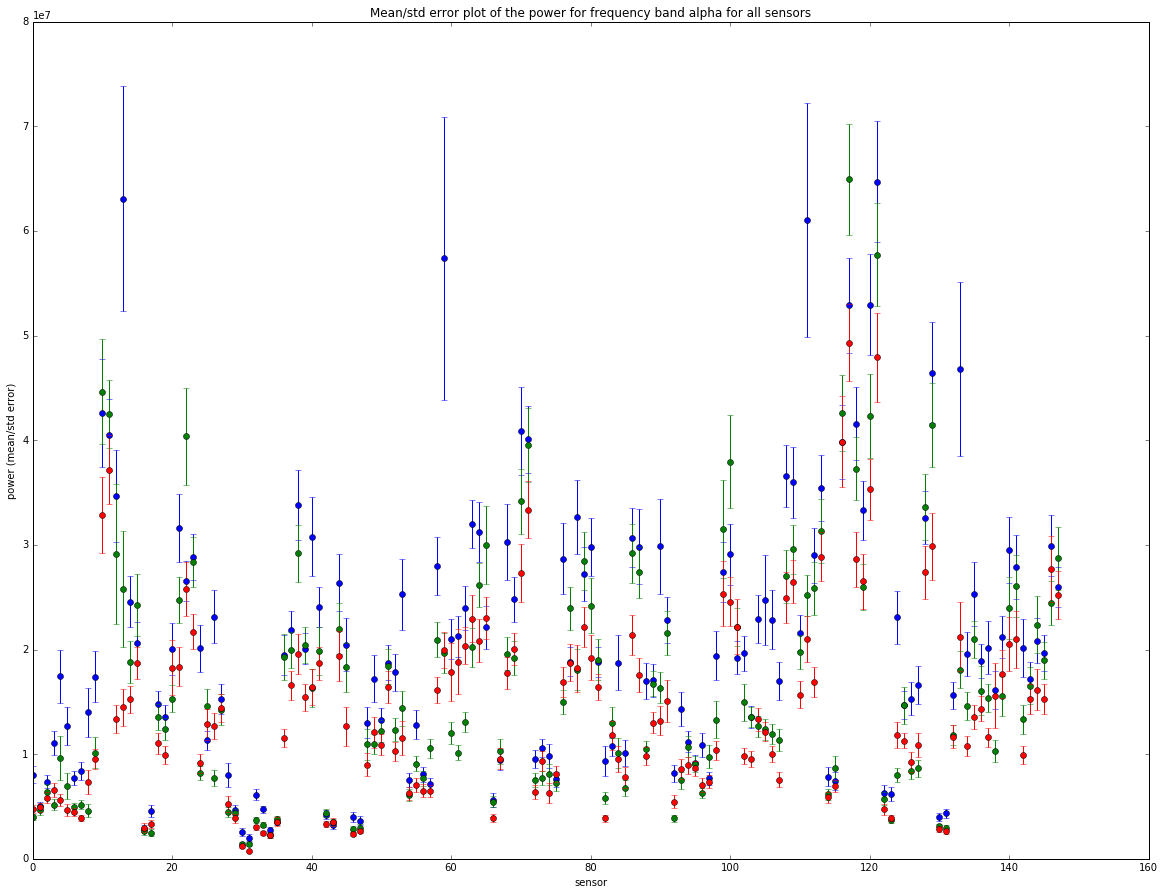

(19374, 148, 5)


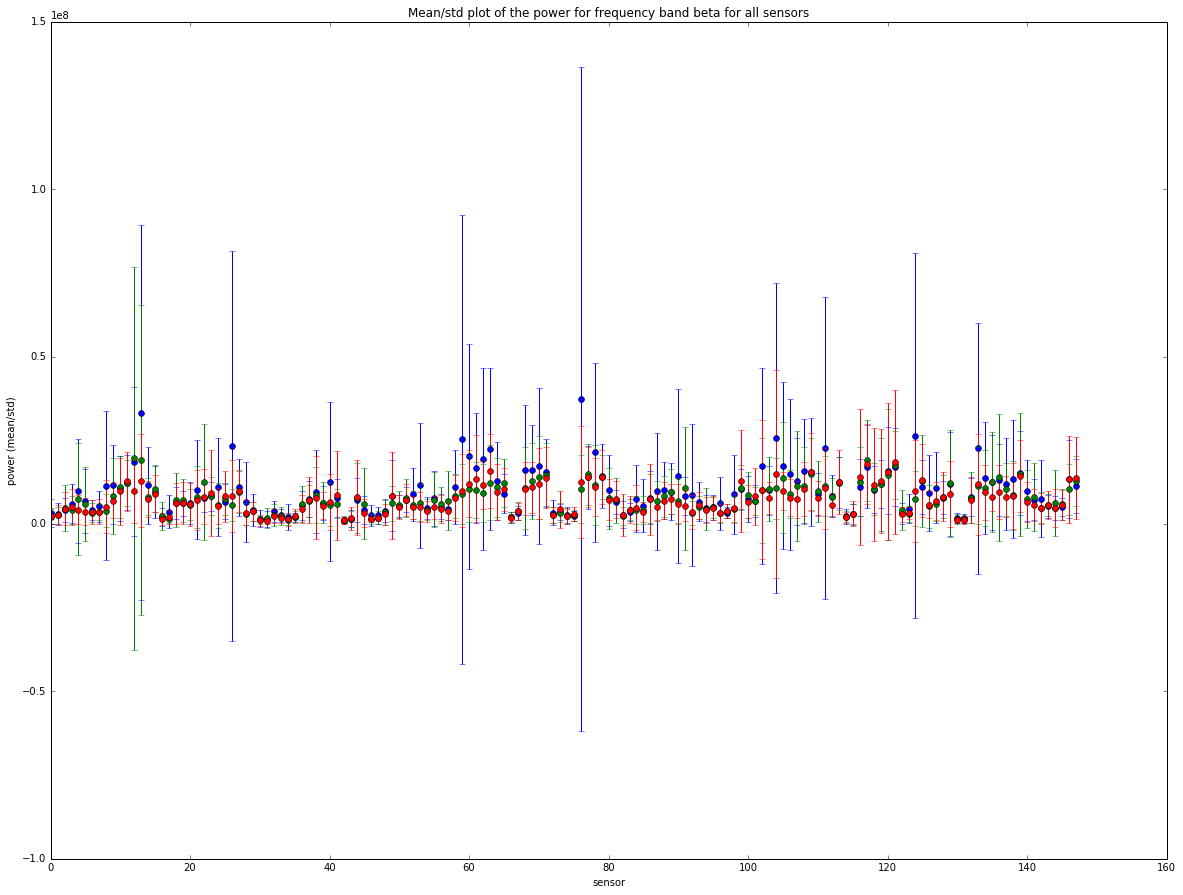

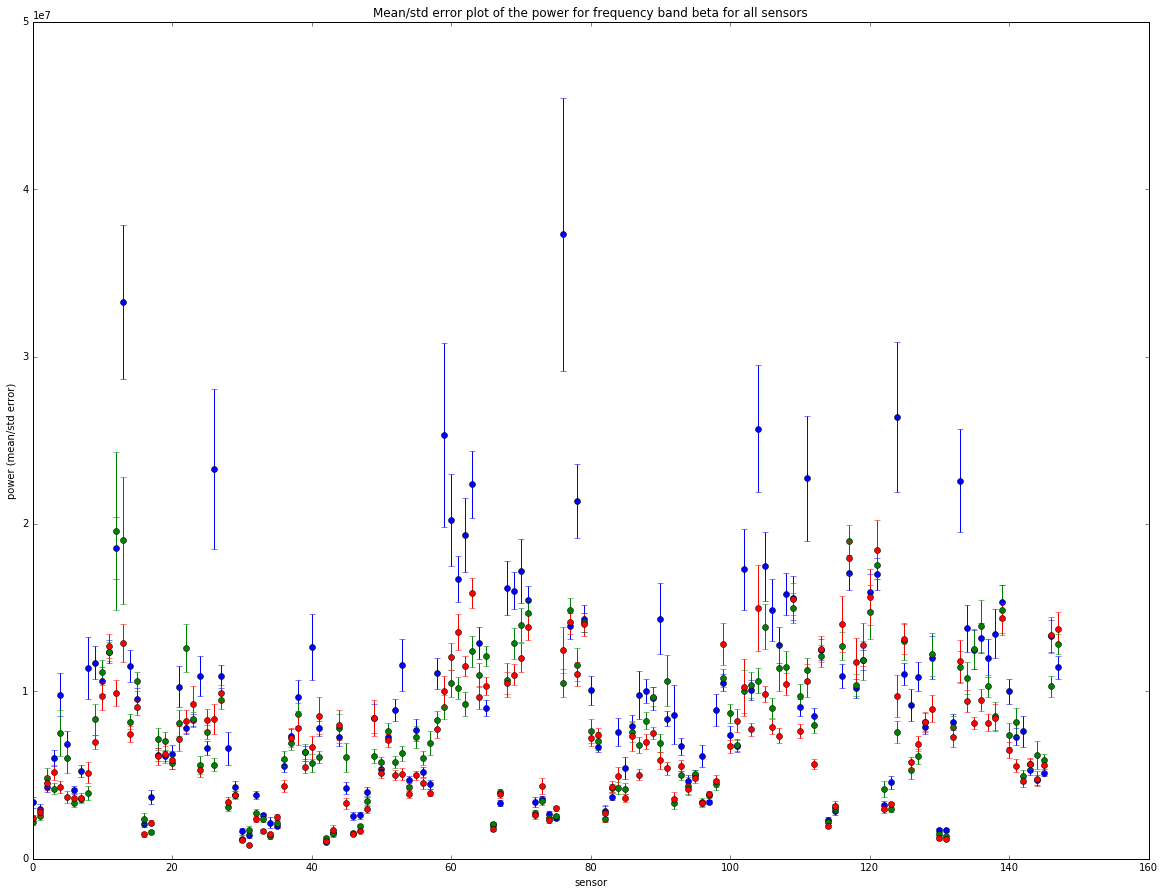

(19374, 148, 5)


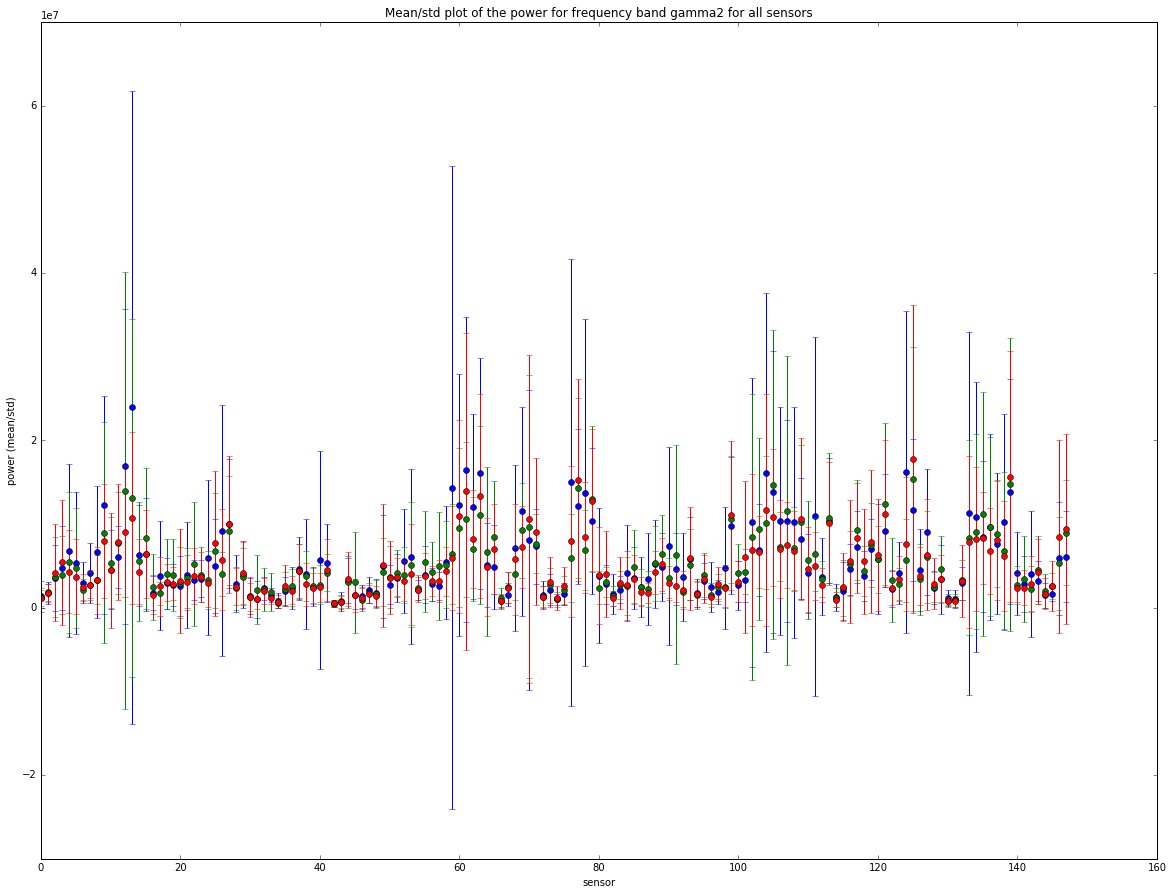

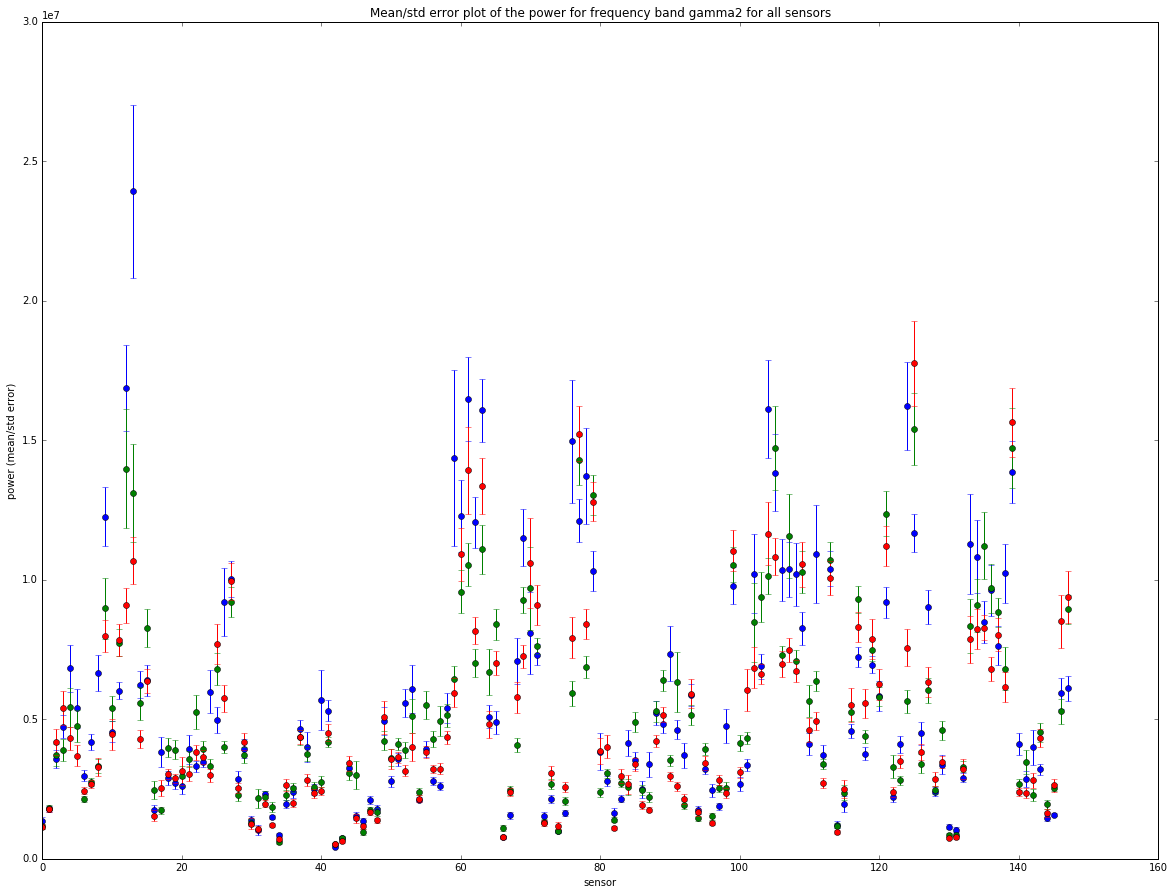

In [31]:
for freq_i, freq in enumerate(frequencies):
    all_monks_x = []
    all_monks_y = []
    for monk_features, monk_targets in data_power:
        all_monks_x.append(monk_features)
        all_monks_y.append(monk_targets)
    all_monks_x = numpy.concatenate(all_monks_x, axis=0)
    all_monks_y = numpy.concatenate(all_monks_y, axis=0)
    
    print all_monks_x.shape
    
    plt.figure(figsize=(20, 15))
    for state_i, state in enumerate(['rest', 'samatha', 'vipassana']):
        state_examples = all_monks_x[all_monks_y==state_i][:, :,freq_i]
        state_means = state_examples.mean(axis=0)
        state_stds = state_examples.std(axis=0)
        
        plt.errorbar(numpy.arange(state_means.shape[0]),
                     state_means,
                     yerr=state_stds,
                     fmt='o')
    plt.xlabel('sensor')
    plt.ylabel('power (mean/std)')
    plt.title('Mean/std plot of the power for frequency band %s for all sensors' % (freq[0]))
    plt.show()
    
    plt.figure(figsize=(20, 15))
    for state_i, state in enumerate(['rest', 'samatha', 'vipassana']):
        state_examples = all_monks_x[all_monks_y==state_i][:, :,freq_i]
        state_means = state_examples.mean(axis=0)
        state_stds = state_examples.std(axis=0)
        
        plt.errorbar(numpy.arange(state_means.shape[0]),
                     state_means,
                     yerr=state_stds/state_means.shape[0]**.5,
                     fmt='o')
    plt.xlabel('sensor')
    plt.ylabel('power (mean/std error)')
    plt.title('Mean/std error plot of the power for frequency band %s for all sensors' % (freq[0]))
    plt.show()
        


#### monk one

(1604, 148, 5)


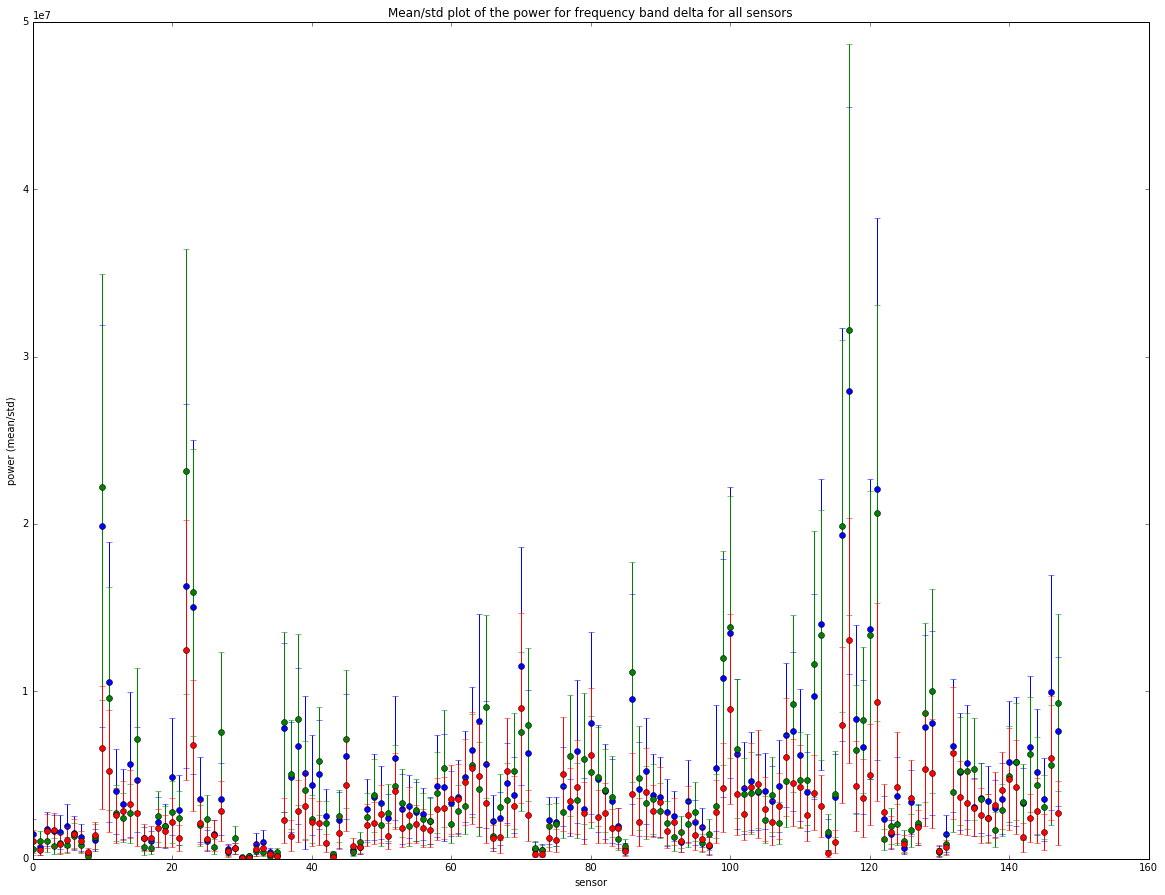

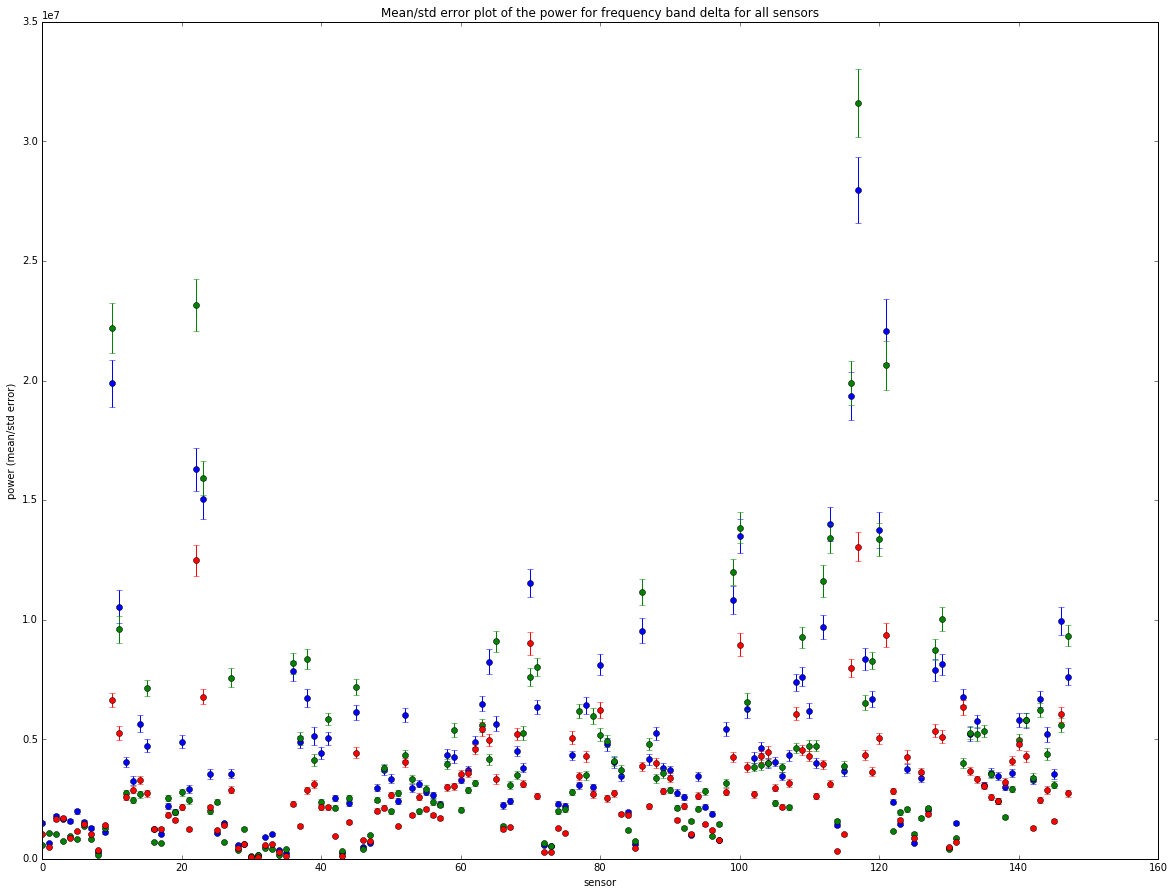

(1604, 148, 5)


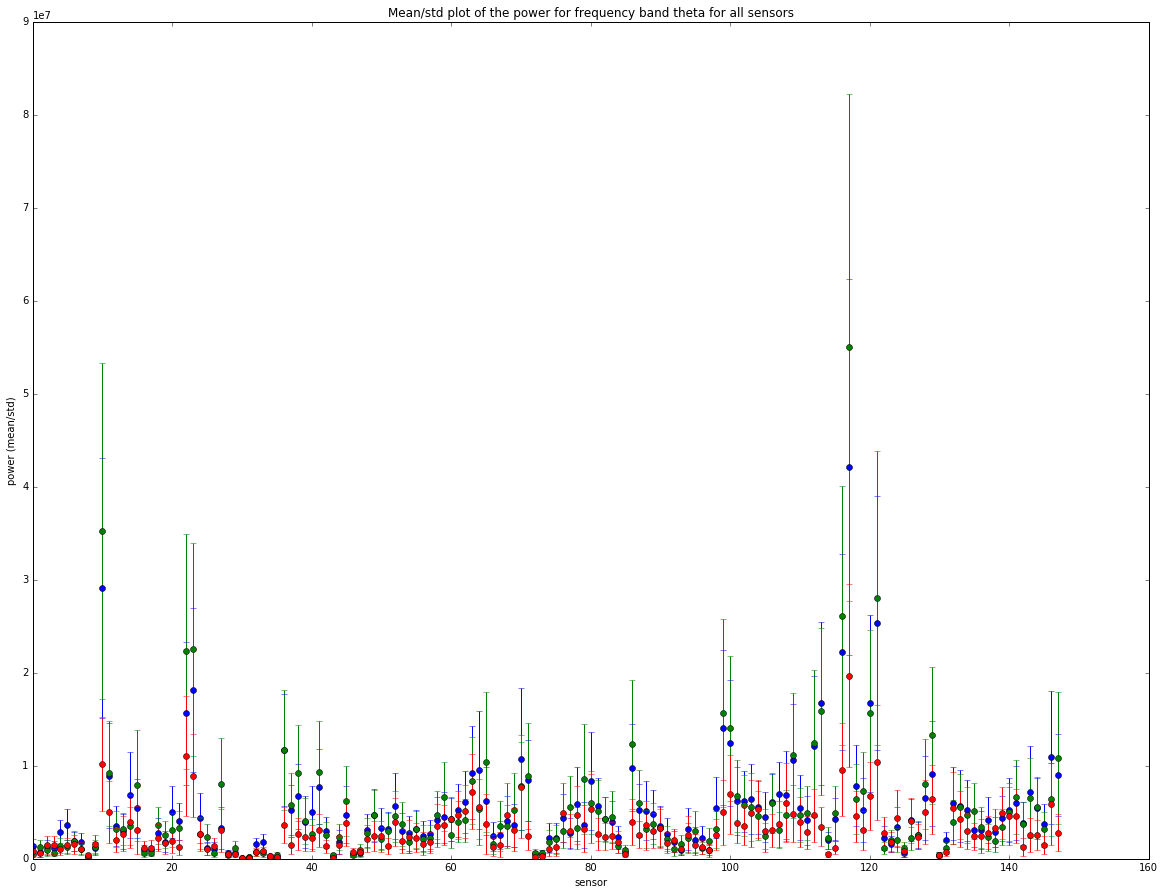

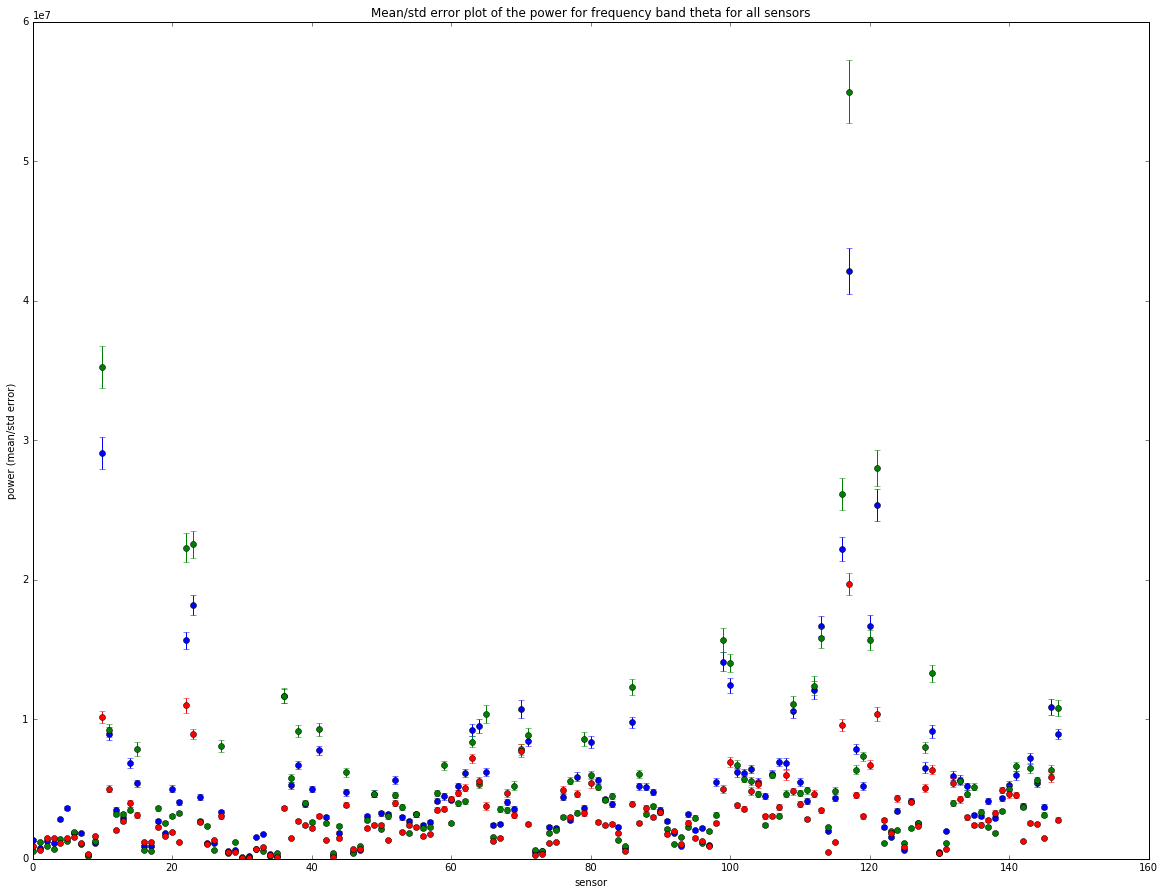

(1604, 148, 5)


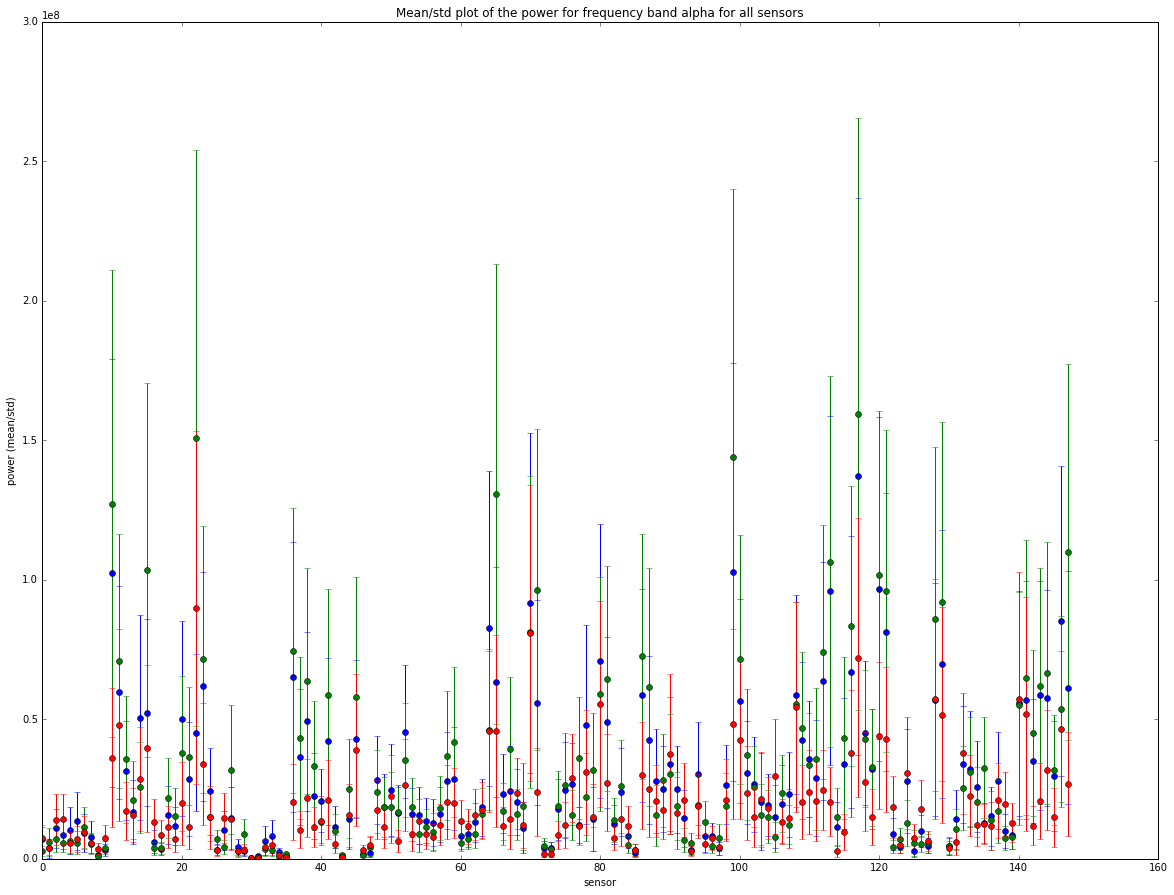

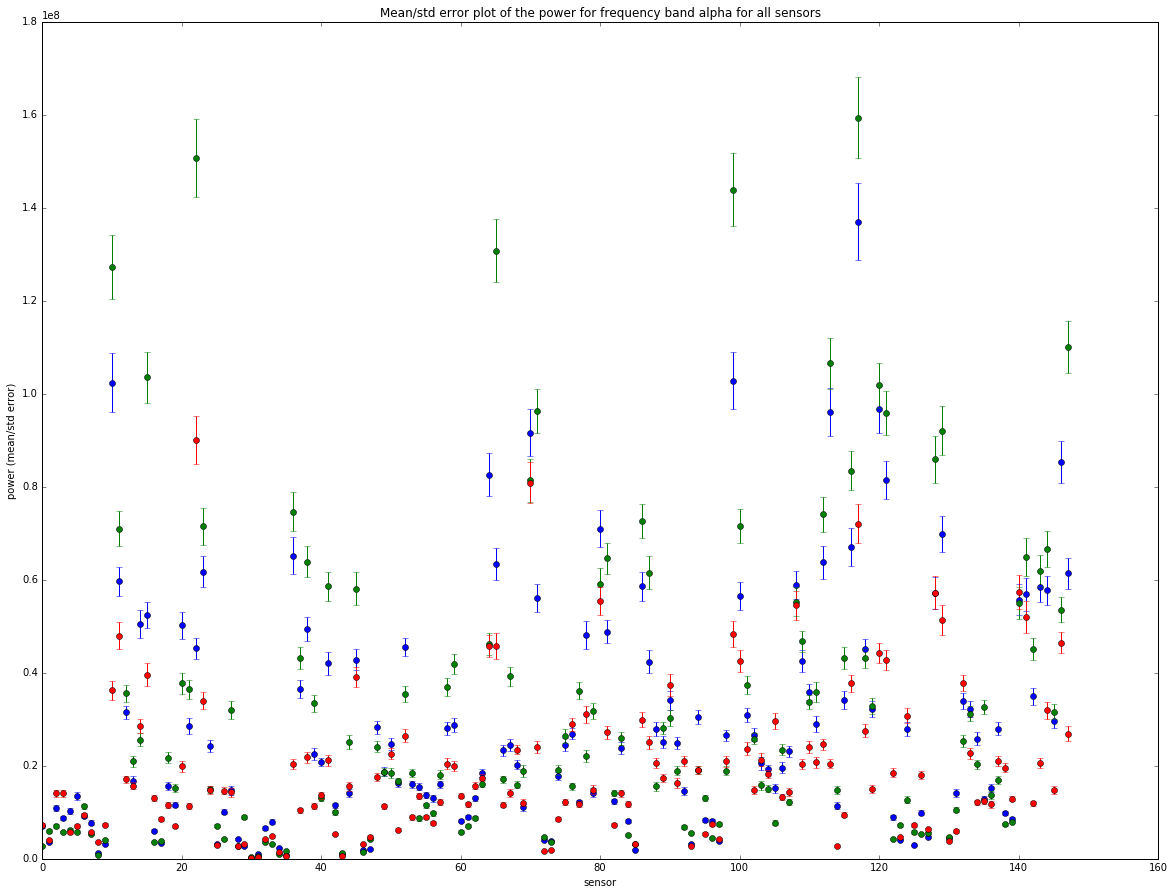

(1604, 148, 5)


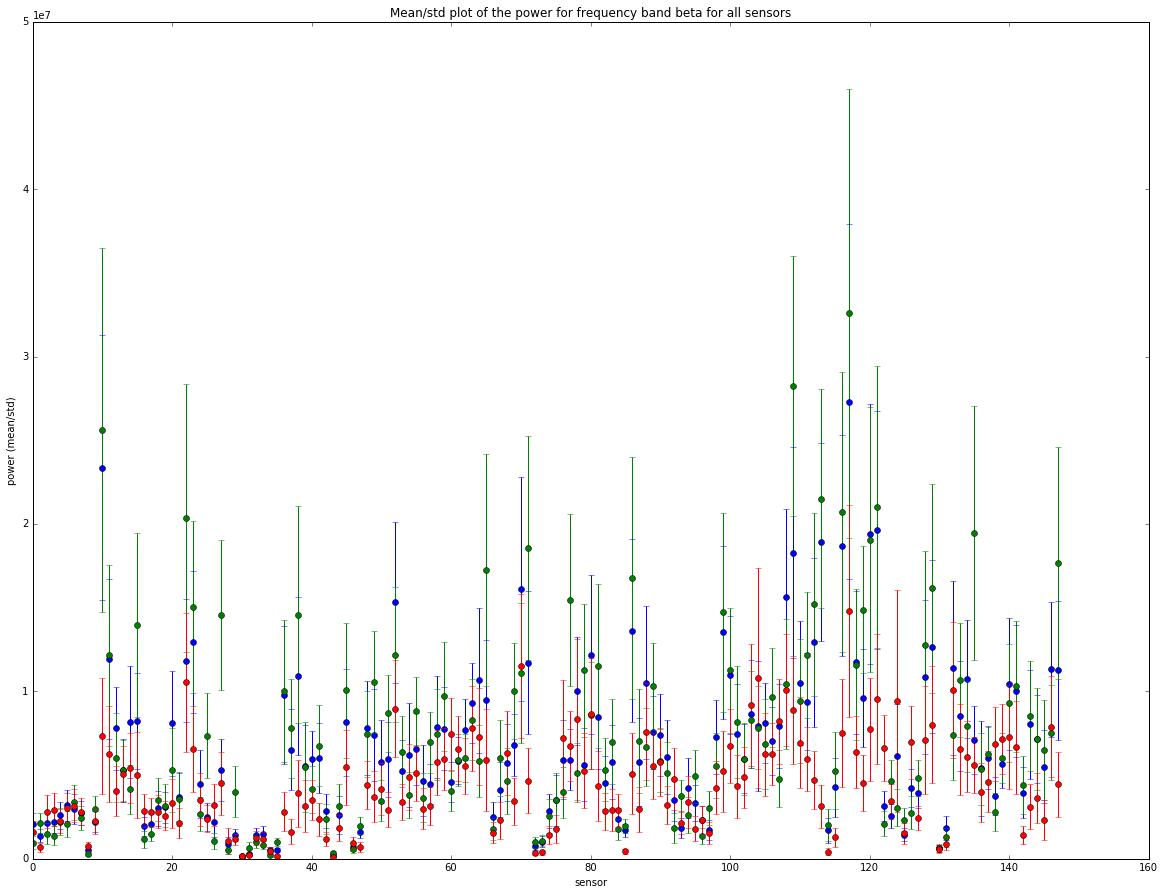

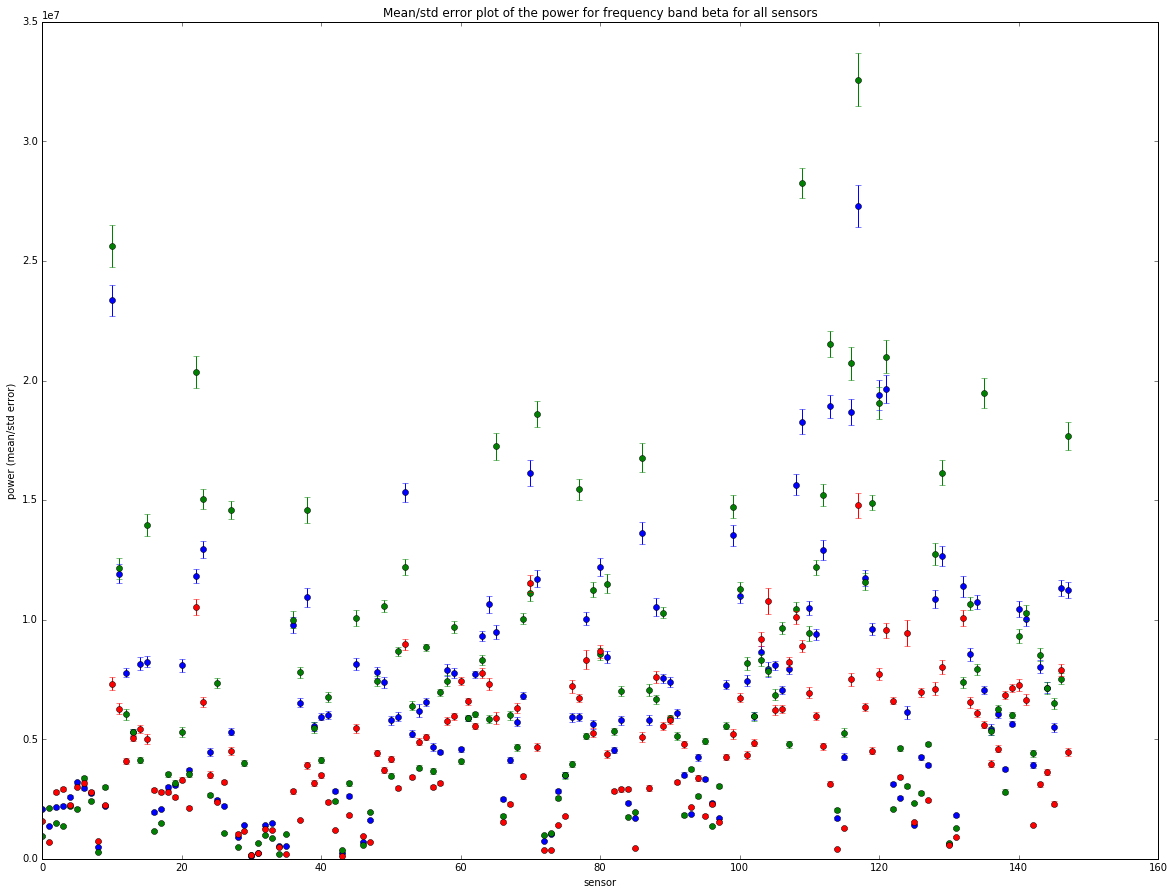

(1604, 148, 5)


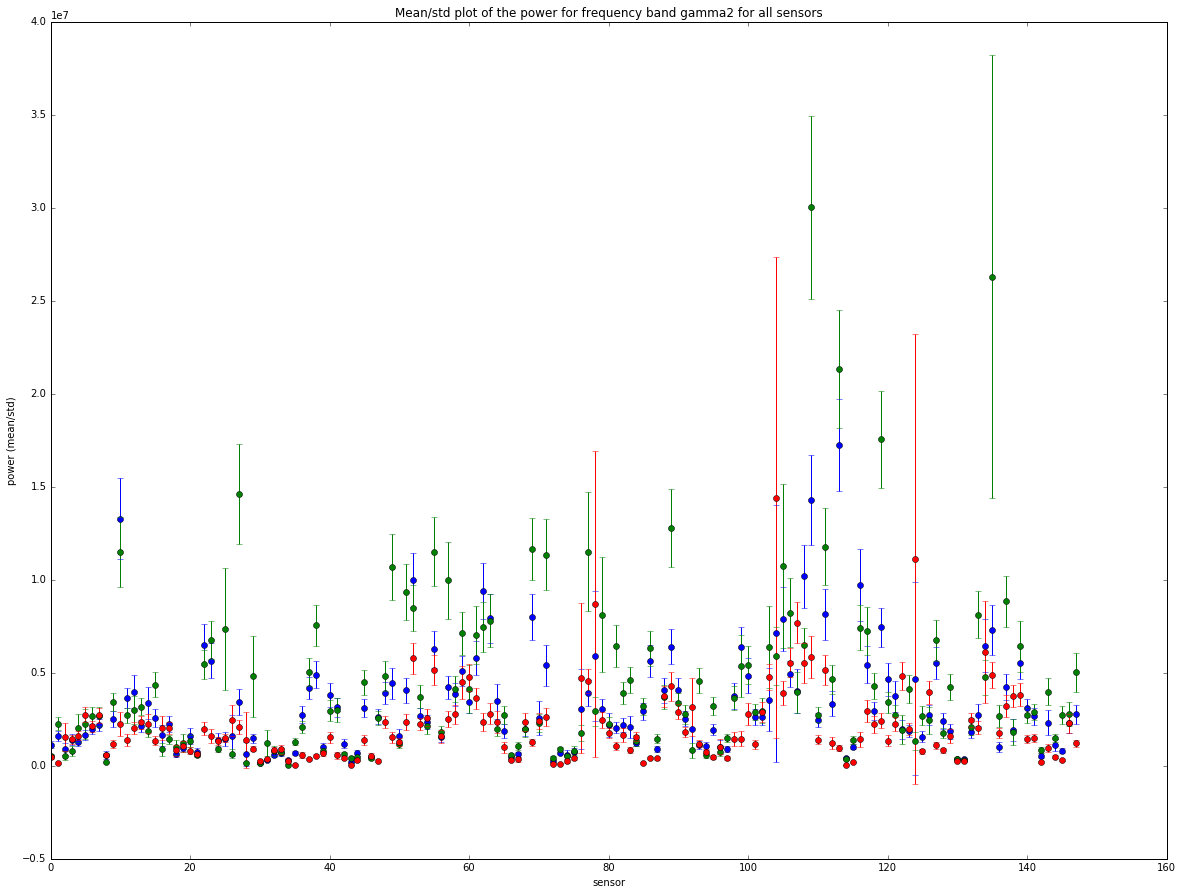

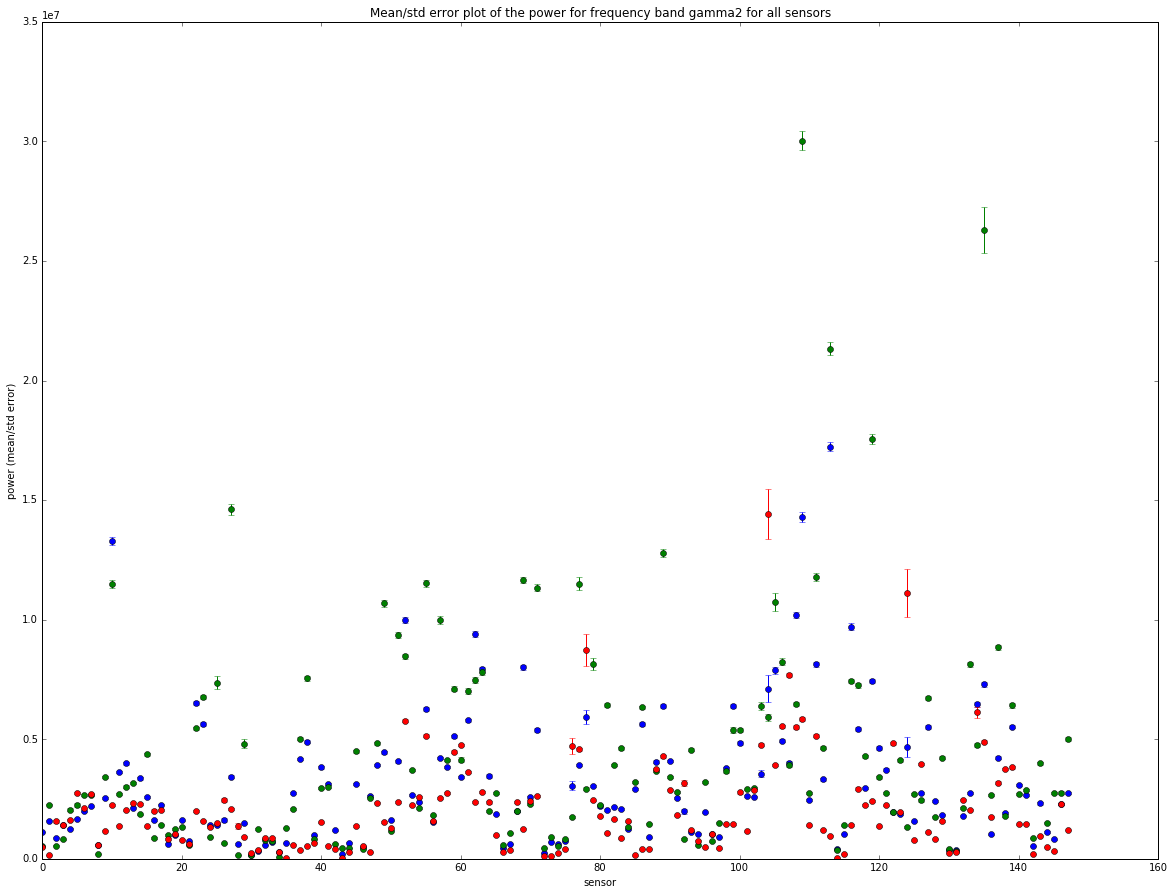

In [32]:
for freq_i, freq in enumerate(frequencies):
    all_monks_x = []
    all_monks_y = []
    for monk_features, monk_targets in data_power:
        all_monks_x.append(monk_features)
        all_monks_y.append(monk_targets)
        break
    all_monks_x = numpy.concatenate(all_monks_x, axis=0)
    all_monks_y = numpy.concatenate(all_monks_y, axis=0)
    
    print all_monks_x.shape
    
    plt.figure(figsize=(20, 15))
    for state_i, state in enumerate(['rest', 'samatha', 'vipassana']):
        state_examples = all_monks_x[all_monks_y==state_i][:, :,freq_i]
        state_means = state_examples.mean(axis=0)
        state_stds = state_examples.std(axis=0)
        
        plt.errorbar(numpy.arange(state_means.shape[0]),
                     state_means,
                     yerr=state_stds,
                     fmt='o')
    plt.xlabel('sensor')
    plt.ylabel('power (mean/std)')
    plt.title('Mean/std plot of the power for frequency band %s for all sensors' % (freq[0]))
    plt.show()
    
    plt.figure(figsize=(20, 15))
    for state_i, state in enumerate(['rest', 'samatha', 'vipassana']):
        state_examples = all_monks_x[all_monks_y==state_i][:, :,freq_i]
        state_means = state_examples.mean(axis=0)
        state_stds = state_examples.std(axis=0)
        
        plt.errorbar(numpy.arange(state_means.shape[0]),
                     state_means,
                     yerr=state_stds/state_means.shape[0]**.5,
                     fmt='o')
    plt.xlabel('sensor')
    plt.ylabel('power (mean/std error)')
    plt.title('Mean/std error plot of the power for frequency band %s for all sensors' % (freq[0]))
    plt.show()
        


### confusions matrices

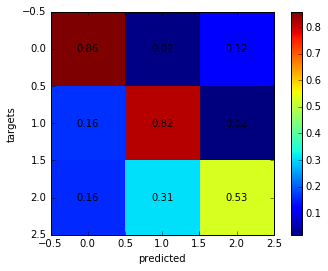

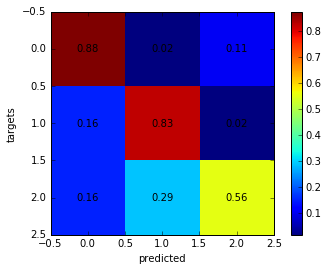

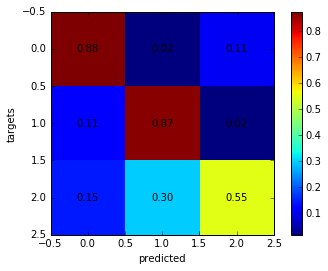

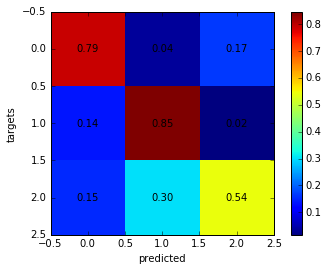

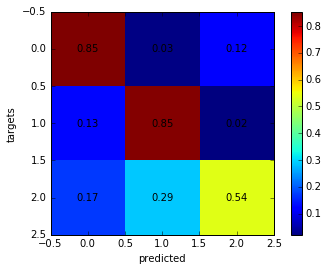

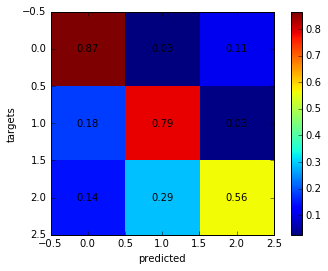

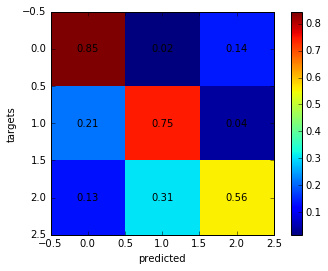

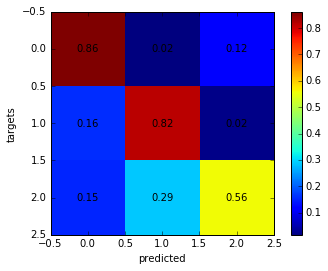

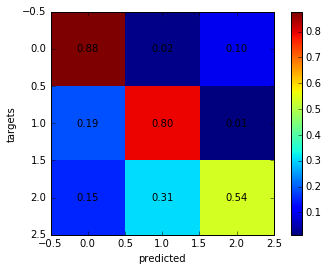

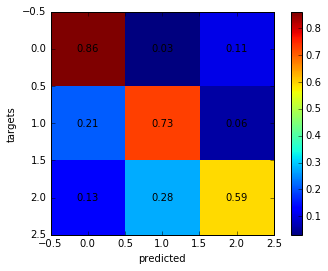

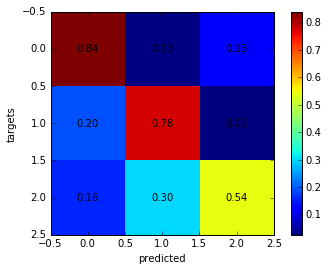

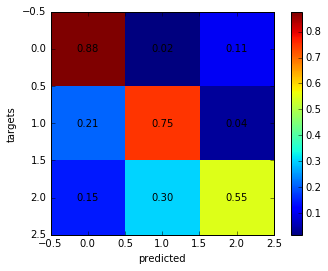

In [18]:
for conf in confusions_train:
    c = conf/conf.sum(axis=1, keepdims=True)
    res = plt.imshow(c, interpolation='nearest')
    for i,j in ((x,y) for x in xrange(3)
            for y in xrange(3)):
        plt.annotate('%.2f' % (c[i][j],),xy=(j,i),horizontalalignment='center',
                    verticalalignment='center')
    plt.xlabel('predicted')
    plt.ylabel('targets')
    plt.colorbar(res)
    plt.show()

## logistic regression

In [20]:
confusions_train = []
confusions_test = []

print 'Train error, test error, test error with random predictor'

for monk_out in range(1, 13):
    confusion_train = numpy.zeros((3, 3))
    confusion_test = numpy.zeros((3, 3))
        
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for monk in range(1, 13):
        if monk == monk_out:
            test_x.append(data_power[monk-1][0])
            test_y.append(data_power[monk-1][1])
        else:
            train_x.append(data_power[monk-1][0])
            train_y.append(data_power[monk-1][1])
        
    train_x = numpy.concatenate(train_x, axis=0)
    train_y = numpy.concatenate(train_y, axis=0)
    train_y_onehot = numpy.zeros((train_y.shape[0], 3))
    train_y_onehot[numpy.arange(train_y.shape[0]), train_y[0]] = 1
    train_x = train_x.reshape(train_x.shape[0], -1)
    test_x = numpy.concatenate(test_x, axis=0)
    test_y = numpy.concatenate(test_y, axis=0)
    test_y_onehot = numpy.zeros((test_y.shape[0], 3))
    test_y_onehot[numpy.arange(test_y.shape[0]), test_y[0]] = 1
    test_x = test_x.reshape(test_x.shape[0], -1)

    
    model = Sequential([
        Dense(3, input_dim=train_x.shape[1]),
        Activation('softmax'),
    ])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    y_fit = model.fit(train_x, train_y_onehot, nb_epoch=25, batch_size=32, verbose=0)
    y_pred_train = numpy.argmax(model.predict(train_x), axis=1)
    y_pred_test = numpy.argmax(model.predict(test_x), axis=1)
    
    for p, t in zip(y_pred_train, train_y):
        confusion_train[p,t] += 1
    for p, t in zip(y_pred_test, test_y):
        confusion_test[p,t] += 1
    confusions_train.append(confusion_train)
    confusions_test.append(confusion_test)
    
    print 'Monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y),
    print float((test_y != numpy.random.randint(0, 3, y_pred_test.shape)).sum()) / len(test_y) 

Train error, test error, test error with random predictor
Monk 1: 0.666010129432 0.700748129676 0.697630922693
Monk 2: 0.637365120615 0.736999402271 0.642558278542
Monk 3: 0.738860688099 0.765815085158 0.695255474453
Monk 4: 0.751502784978 0.68815471394 0.666398066076
Monk 5: 0.583200364714 0.395399780942 0.679079956188
Monk 6: 0.641540283024 0.619425778864 0.673182651191
Monk 7: 0.768812330009 0.703939745075 0.662224797219
Monk 8: 0.622298456261 0.642250530786 0.661889596603
Monk 9: 0.601941199707 0.842710223835 0.663641863279
Monk 10: 0.600756648492 0.79 0.674285714286
Monk 11: 0.663899018233 0.838605551969 0.658489347966
Monk 12: 0.634804058979 0.608978529603 0.674040338321


### confusion matrices

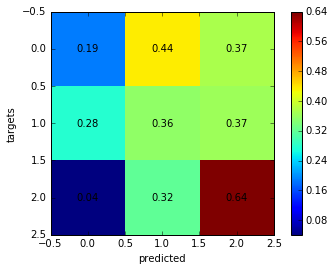

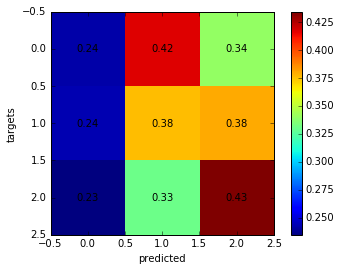

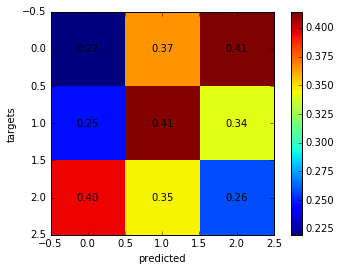

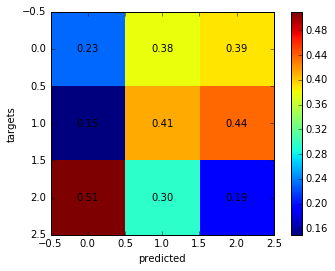

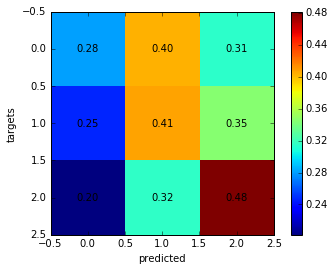

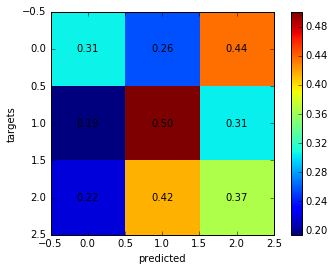

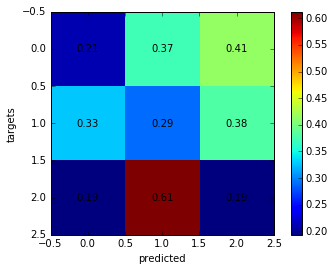

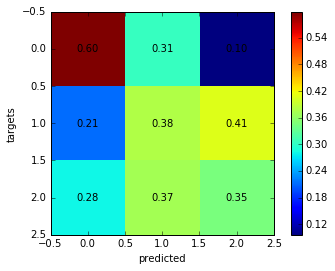

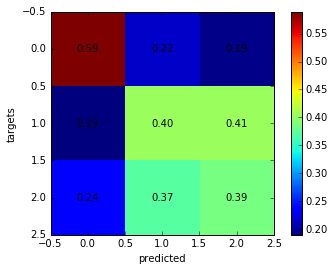

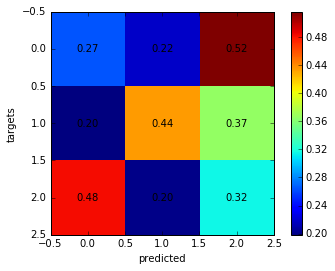

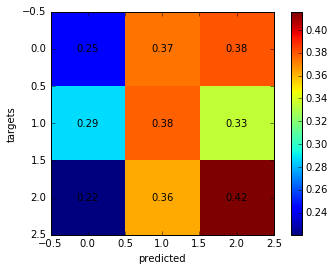

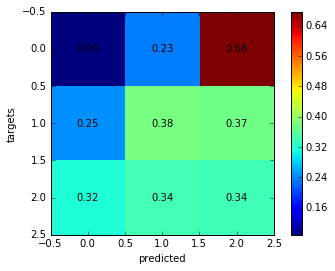

In [21]:
for conf in confusions_train:
    c = conf/conf.sum(axis=1, keepdims=True)
    res = plt.imshow(c, interpolation='nearest')
    for i,j in ((x,y) for x in xrange(3)
            for y in xrange(3)):
        plt.annotate('%.2f' % (c[i][j],),
                     xy=(j,i),
                     horizontalalignment='center',
                     verticalalignment='center')
    plt.xlabel('predicted')
    plt.ylabel('targets')
    plt.colorbar(res)
    plt.show()

### rest vs non rest

In [36]:
confusions_train = []
confusions_test = []

print 'Train error, test error, test error with random predictor'

for monk_out in range(1, 13):
    confusion_train = numpy.zeros((3, 3))
    confusion_test = numpy.zeros((3, 3))
        
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for monk in range(1, 13):
        if monk == monk_out:
            test_x.append(data_power[monk-1][0])
            test_y.append((data_power[monk-1][1]>0)*1)
        else:
            train_x.append(data_power[monk-1][0])
            train_y.append((data_power[monk-1][1]>0)*1)
        
    train_x = numpy.concatenate(train_x, axis=0)
    train_y = numpy.concatenate(train_y, axis=0)
    train_y_onehot = numpy.zeros((train_y.shape[0], 2))
    train_y_onehot[numpy.arange(train_y.shape[0]), train_y[0]] = 1
    train_x = train_x.reshape(train_x.shape[0], -1)
    test_x = numpy.concatenate(test_x, axis=0)
    test_y = numpy.concatenate(test_y, axis=0)
    test_y_onehot = numpy.zeros((test_y.shape[0], 2))
    test_y_onehot[numpy.arange(test_y.shape[0]), test_y[0]] = 1
    test_x = test_x.reshape(test_x.shape[0], -1)

    
    model = Sequential([
        Dense(2, input_dim=train_x.shape[1]),
        Activation('softmax'),
    ])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    y_fit = model.fit(train_x, train_y_onehot, nb_epoch=25, batch_size=32, verbose=0)
    y_pred_train = numpy.argmax(model.predict(train_x), axis=1)
    y_pred_test = numpy.argmax(model.predict(test_x), axis=1)
    
    for p, t in zip(y_pred_train, train_y):
        confusion_train[p,t] += 1
    for p, t in zip(y_pred_test, test_y):
        confusion_test[p,t] += 1
    confusions_train.append(confusion_train)
    confusions_test.append(confusion_test)
    
    print 'Monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y),
    most_frequent = numpy.argmax(numpy.bincount(train_y))
    print float((test_y != most_frequent).sum()) / len(test_y) 

Train error, test error, test error with random predictor
Monk 1: 0.249634214969 0.209476309227 0.184538653367
Monk 2: 0.68476357268 0.763897190675 0.235505080693
Monk 3: 0.251212633954 0.231751824818 0.231751824818
Monk 4: 0.294380411405 0.203062046737 0.412570507655
Monk 5: 0.472019603374 0.462760131435 0.282584884995
Monk 6: 0.743079438462 0.799022602321 0.20036652413
Monk 7: 0.682966908432 0.834298957126 0.238702201622
Monk 8: 0.365637507147 0.579617834395 0.298832271762
Monk 9: 0.264319169347 0.243799153055 0.233514821537
Monk 10: 0.461722488038 0.535714285714 0.233571428571
Monk 11: 0.263001402525 0.158812136862 0.186571981924
Monk 12: 0.548690923362 0.530253741054 0.167859466493


## one hidden layer

In [22]:
confusions_train = []
confusions_test = []

print 'Train error, test error, test error with random predictor'

for monk_out in range(1, 13):
    confusion_train = numpy.zeros((3, 3))
    confusion_test = numpy.zeros((3, 3))
        
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for monk in range(1, 13):
        if monk == monk_out:
            test_x.append(data_power[monk-1][0])
            test_y.append(data_power[monk-1][1])
        else:
            train_x.append(data_power[monk-1][0])
            train_y.append(data_power[monk-1][1])
        
    train_x = numpy.concatenate(train_x, axis=0)
    train_y = numpy.concatenate(train_y, axis=0)
    train_y_onehot = numpy.zeros((train_y.shape[0], 3))
    train_y_onehot[numpy.arange(train_y.shape[0]), train_y[0]] = 1
    train_x = train_x.reshape(train_x.shape[0], -1)
    test_x = numpy.concatenate(test_x, axis=0)
    test_y = numpy.concatenate(test_y, axis=0)
    test_y_onehot = numpy.zeros((test_y.shape[0], 3))
    test_y_onehot[numpy.arange(test_y.shape[0]), test_y[0]] = 1
    test_x = test_x.reshape(test_x.shape[0], -1)

    
    model = Sequential([
        Dense(100, input_dim=train_x.shape[1]),
        Activation('relu'),
        Dense(3),
        Activation('softmax'),
    ])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    y_fit = model.fit(train_x, train_y_onehot, nb_epoch=200, batch_size=32, verbose=0)
    y_pred_train = numpy.argmax(model.predict(train_x), axis=1)
    y_pred_test = numpy.argmax(model.predict(test_x), axis=1)
    
    for p, t in zip(y_pred_train, train_y):
        confusion_train[p,t] += 1
    for p, t in zip(y_pred_test, test_y):
        confusion_test[p,t] += 1
    confusions_train.append(confusion_train)
    confusions_test.append(confusion_test)
    
    print 'Monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y),
    print float((test_y != numpy.random.randint(0, 3, y_pred_test.shape)).sum()) / len(test_y) 

Train error, test error, test error with random predictor
Monk 1: 0.622172200338 0.596009975062 0.65710723192
Monk 2: 0.691147392803 0.751942618051 0.660490137478
Monk 3: 0.747941342358 0.734184914842 0.666058394161
Monk 4: 0.656978988584 0.274778404512 0.67042707494
Monk 5: 0.753134260315 0.820372398686 0.673603504929
Monk 6: 0.700343913852 0.642638973732 0.656078191814
Monk 7: 0.683986854034 0.614716106605 0.668597914253
Monk 8: 0.593367638651 0.644373673036 0.643842887473
Monk 9: 0.672761130862 0.744101633394 0.686630369026
Monk 10: 0.643373762101 0.552142857143 0.662142857143
Monk 11: 0.637251051893 0.602324080052 0.659780503551
Monk 12: 0.651903346975 0.614183474301 0.650618087183


### confusion matrices

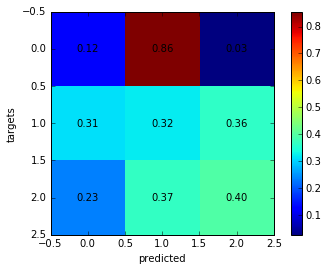

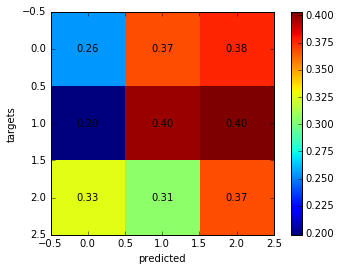

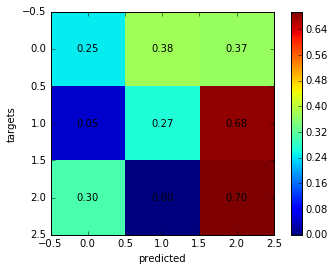

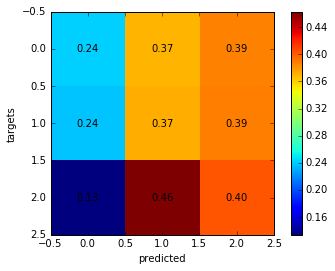

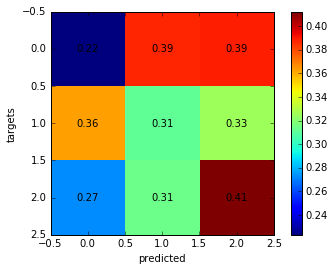

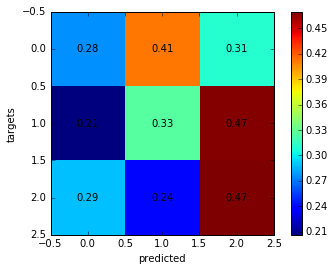

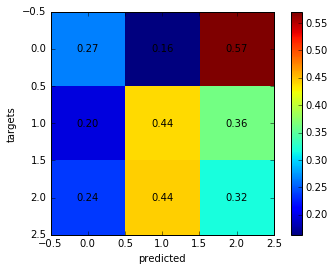

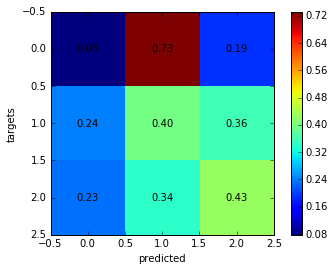

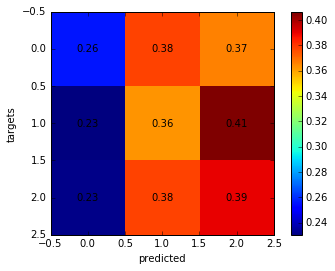

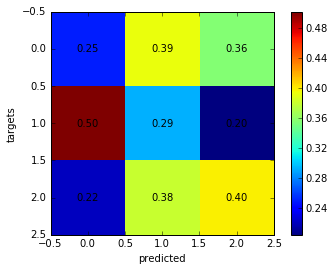

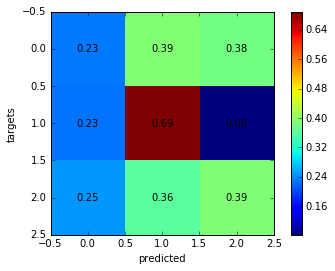

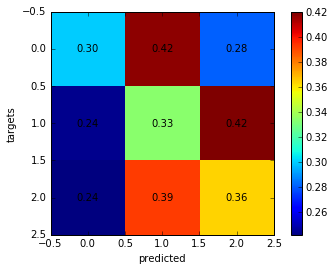

In [23]:
for conf in confusions_train:
    c = conf/conf.sum(axis=1, keepdims=True)
    res = plt.imshow(c, interpolation='nearest')
    for i,j in ((x,y) for x in xrange(3)
            for y in xrange(3)):
        plt.annotate('%.2f' % (c[i][j],),
                     xy=(j,i),
                     horizontalalignment='center',
                     verticalalignment='center')
    plt.xlabel('predicted')
    plt.ylabel('targets')
    plt.colorbar(res)
    plt.show()

## 1 nearest neighbours

In [27]:
confusions_train = []
confusions_test = []

for monk_out in range(1, 13):
    confusion_train = numpy.zeros((3,3))
    confusion_test = numpy.zeros((3,3))
    
    print 'I will leave monk %d out' % (monk_out)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for monk in range(1, 13):
        if monk == monk_out:
            test_x.append(data_power[monk-1][0])
            test_y.append(data_power[monk-1][1])
        else:
            train_x.append(data_power[monk-1][0])
            train_y.append(data_power[monk-1][1])
        
    train_x = numpy.concatenate(train_x, axis=0)
    train_y = numpy.concatenate(train_y, axis=0)
    train_x = train_x.reshape(train_x.shape[0], -1)
    test_x = numpy.concatenate(test_x, axis=0)
    test_y = numpy.concatenate(test_y, axis=0)
    test_x = test_x.reshape(test_x.shape[0], -1)
    
    knn = KNeighborsClassifier(n_neighbors=1)
    
    y_fit = knn.fit(train_x, train_y)
    y_pred_train = y_fit.predict(train_x)
    y_pred_test = y_fit.predict(test_x)
    
    for p, t in zip(y_pred_train, train_y):
        confusion_train[p,t] += 1
    for p, t in zip(y_pred_test, test_y):
        confusion_test[p,t] += 1
    confusions_train.append(confusion_train)
    confusions_test.append(confusion_test)
    
    print 'Misclassified for monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y)

I will leave monk 1 out
Misclassified for monk 1: 0.0 0.554239401496
I will leave monk 2 out
Misclassified for monk 2: 0.0 0.682606096832
I will leave monk 3 out
Misclassified for monk 3: 0.0 0.600364963504
I will leave monk 4 out
Misclassified for monk 4: 0.0 0.545527800161
I will leave monk 5 out
Misclassified for monk 5: 0.0 0.733844468784
I will leave monk 6 out
Misclassified for monk 6: 0.0 0.751374465486
I will leave monk 7 out
Misclassified for monk 7: 0.0 0.758980301275
I will leave monk 8 out
Misclassified for monk 8: 0.0 0.676220806794
I will leave monk 9 out
Misclassified for monk 9: 0.0 0.667876588022
I will leave monk 10 out
Misclassified for monk 10: 0.0 0.65
I will leave monk 11 out
Misclassified for monk 11: 0.0 0.650742414461
I will leave monk 12 out
Misclassified for monk 12: 0.0 0.728692257645
